# Torch tests 

In [1]:
import colorsys, contextlib, datetime, os, pathlib, platform, pprint, sys
import gtda
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import PIL.Image as Image
import plotly as py
import plotly.graph_objs as go
import plotly.io as pio
import pomegranate as pg
import seaborn as sns
import sdv
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import yellowbrick as yb

fastai_gpu_conflict = True
if(fastai_gpu_conflict):
    torch.cuda.is_available = lambda : False


from collections import namedtuple, ChainMap

import fastai
import fastcore
from fastai.basics import Tensor
from fastai.callback.all import CollectDataCallback, Callback, ProgressCallback
from fastai.callback.all import LRFinder, EarlyStoppingCallback, SaveModelCallback, ShowGraphCallback, CSVLogger, slide, steep, minimum, valley
from fastai.data.all import Transform, DisplayedTransform
from fastai.layers import Cat, Identity
from fastai.metrics import MatthewsCorrCoef, F1Score, Recall, Precision, RocAuc, BalancedAccuracy
from fastai.optimizer import ranger, Adam
from fastai.tabular.data import TabularDataLoaders, TabularPandas, MultiCategoryBlock
from fastai.tabular.all import delegates, tabular_config, TabularLearner, get_c, ifnone, is_listy, LinBnDrop, SigmoidRange 
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, range_of
from fastai.tabular.all import get_emb_sz, Module, Learner, Embedding, CrossEntropyLossFlat, IndexSplitter, ColSplitter, RandomSplitter
from fastai.test_utils import synth_learner, VerboseCallback
from fastai.torch_core import Enum

from fastcore.all import Transform, store_attr, L

# from pytorch_tabnet.tab_network import TabNetNoEmbeddings
# from fast_tabnet.core import TabNetModel as TabNet, tabnet_feature_importances, tabnet_explain

from gtda.curves import Derivative, StandardFeatures
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, PersistenceImage, BettiCurve, Silhouette, HeatKernel
from gtda.homology import VietorisRipsPersistence, EuclideanCechPersistence
from gtda.plotting import plot_diagram, plot_point_cloud, plot_betti_curves, plot_betti_surfaces

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

from sdv.metrics.tabular import MulticlassDecisionTreeClassifier, CSTest, KSTest, ContinuousKLDivergence, BNLikelihood, GMLogLikelihood, LogisticDetection, MulticlassMLPClassifier, BNLogLikelihood
from sdv.tabular import TVAE, CopulaGAN, CTGAN, GaussianCopula
from sdv.evaluation import evaluate

from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from torch.utils.data import Dataset, DataLoader

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve

seed: int = 14

# allow plots to be shown in the notebook
init_notebook_mode(connected=True)
# pio.renderers.default = "iframe"



device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set up pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# print library and python versions for reproducibility
print(
    f'''
    Last Execution: {datetime.datetime.now()}
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tgiotto-tda:\t{gtda.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tplotly:\t\t{py.__version__}
    \tseaborn:\t{sns.__version__}
    \tsdv:\t\t{sdv.__version__}
    \tsklearn:\t{sklearn.__version__}
    \ttorch:\t\t{torch.__version__}
    \tyellowbrick:\t{yb.__version__}

    \tdevice:\t\t{device}
    '''
)


    Last Execution: 2022-04-23 23:14:19.587684
    python:	3.7.10

    	fastai:		2.4.1
    	giotto-tda:	0.5.1
    	matplotlib:	3.5.1
    	numpy:		1.20.3
    	pandas:		1.3.4
    	plotly:		5.6.0
    	seaborn:	0.11.2
    	sdv:		0.13.1
    	sklearn:	1.0.2
    	torch:		1.9.0
    	yellowbrick:	1.3.post1

    	device:		cpu
    


First we create some helper functions to load and process the data

In [2]:
def get_file_path(directory: str) -> callable:
    '''
        Closure that will return a function. 
        Function will return the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func



def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    p = pathlib.Path(filePath)

    filePathClean: str = str(p.parts[-1])
    pickleDump   : str = f'./cache/{filePathClean}.pickle'

    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')


    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
 
    # if not, load data and clean it before caching it
    else:
        df: pd.DataFrame = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)
    
    return df



def features_with_bad_values(df: pd.DataFrame, datasetName: str) -> pd.DataFrame:
    '''
        Function will scan the dataframe for features with Inf, NaN, or Zero values.
        Returns a new dataframe describing the distribution of these values in the original dataframe
    '''

    # Inf and NaN values can take different forms so we screen for every one of them
    invalid_values: list = [ np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan', 0 ]
    infs          : list = [ np.inf, 'Infinity', 'inf' ]
    NaNs          : list = [ np.nan, 'NaN', 'nan' ]

    # We will collect stats on the dataset, specifically how many instances of Infs, NaNs, and 0s are present.
    # using a dictionary that will be converted into a (3, n) dataframe where n is the number of features in the dataset
    stats: dict = {
        'Dataset':[ datasetName, datasetName, datasetName ],
        'Value'  :['Inf', 'NaN', 'Zero']
    }

    i = 0
    for col in df.columns:
        
        i += 1
        feature = np.zeros(3)
        
        for value in invalid_values:
            if value in infs:
                j = 0
            elif value in NaNs:
                j = 1
            else:
                j = 2
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                feature[j] += len(indexNames)
                
        stats[col] = feature

    return pd.DataFrame(stats)



def clean_data(df: pd.DataFrame, prune: list) -> pd.DataFrame:
    '''
        Function will take a dataframe and remove the columns that match a value in prune 
        Inf and Nan values will also be removed once appropriate rows and columns 
        have been removed, 
        we will return the dataframe with the appropriate values
    '''

    # remove the features in the prune list    
    for col in prune:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    
    # drop missing values/NaN etc.
    df.dropna(inplace=True)

    
    # Search through dataframe for any Infinite or NaN values in various forms that were not picked up previously
    invalid_values: list = [
        np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan'
    ]
    
    for col in df.columns:
        for value in invalid_values:
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                print(f'deleting {len(indexNames)} rows with Infinity in column {col}')
                df.drop(indexNames, inplace=True)

    return df



def examine_dataset(job_id: int, files: str or None = None, datasets: str or None = None) -> ChainMap:
    '''
        Function will return a dictionary containing dataframe of the job_id passed in as well as that dataframe's
        feature stats, data composition, and file name.

        This dictionary is expected as the input for all of the other helper functions
    '''
    if files is None and file_set in globals():
        files = file_set

    if datasets is None and data_set in globals():
        datasets = data_set


    job_id = job_id - 1  # adjusts for indexing while enumerating jobs from 1
    print(f'Dataset {job_id+1}/{len(datasets)}: We now look at {files[job_id]}\n\n')

    # Load the dataset
    df: pd.DataFrame = load_data(files[job_id])
 

    # print the data composition
    print(f'''
        File:\t\t\t\t{files[job_id]}  
        Job Number:\t\t\t{job_id+1}
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats in a chainmap. This is a dictionary that can be
    #     updated by other functions, grouping together dictionaries and only showing the keys
    #     that appear first in the chainmap. This is useful for transforming the dataset and 
    #     performing experiments, so we can keep track of the history and do not need to reload
    #     the dataset.
    data_summary: ChainMap =  ChainMap({
        'File':             files[job_id],
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, files[job_id]), 
    })
    
    return data_summary



def package_data_for_inspection(df: pd.DataFrame) -> ChainMap:
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
    Packaging Data:

    Dataset statistics:
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: ChainMap =  ChainMap({
        'File':             '',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, ''), 
    })
    
    return data_summary



def package_data_for_inspection_with_label(df: pd.DataFrame, label: str) -> ChainMap:
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
    Packaging Data {label}:

    Dataset statistics:
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: ChainMap =  ChainMap({
        'File':             f'{label}',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, f'{label}'),
    })
    
    return data_summary



def check_infs(data_summary: ChainMap) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of Inf.
    '''

    
    vals: pd.DataFrame = data_summary['Feature_stats']
    inf_df = vals[vals['Value'] == 'Inf'].T

    return inf_df[inf_df[0] != 0]



def check_nans(data_summary: ChainMap) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of NaN.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    nan_df = vals[vals['Value'] == 'NaN'].T

    return nan_df[nan_df[1] != 0]



def check_zeros(data_summary: ChainMap) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of 0.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    zero_df = vals[vals['Value'] == 'Zero'].T

    return zero_df[zero_df[2] != 0]



def check_zeros_over_threshold(data_summary: ChainMap, threshold: int) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of 0.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    zero_df = vals[vals['Value'] == 'Zero'].T
    zero_df_bottom = zero_df[2:]

    return zero_df_bottom[zero_df_bottom[2] > threshold]



def check_zeros_over_threshold_percentage(data_summary: ChainMap, threshold: float) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with all features with
        a frequency of 0 values greater than the threshold
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    size: int = data_summary['Dataset'].shape[0]
    zero_df = vals[vals['Value'] == 'Zero'].T
    zero_df_bottom = zero_df[2:]

    return zero_df_bottom[zero_df_bottom[2] > threshold*size]



def remove_infs_and_nans(data_summary: ChainMap) -> pd.DataFrame:
    '''
        Function will return the dataset with all inf and nan values removed.
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    df = clean_data(df, [])

    return df



def rename_columns(data_summary: ChainMap, columns: list, new_names: list) -> ChainMap:
    '''
        Function will return the data_summary dict with the names of the columns in the dataframe changed
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    for x, i in enumerate(columns):
        df.rename(columns={i: new_names[x]}, inplace=True)

    out: dict = {'Dataset': df}

    return data_summary.new_child(out)



def rename_values_in_column(data_summary: ChainMap, replace: list) -> pd.DataFrame:
    '''
        Function will return a dataframe with the names of the columns changed

        replace: [('column', {'old_name': 'new_name', ...}), ...]
    '''
    length: int = len(replace)

    df: pd.DataFrame = data_summary['Dataset'].copy()
    for i in range(length):
        df[replace[i][0]].replace(replace[i][1], inplace=True)


    return df



def rename_values_in_column_df(df: pd.DataFrame, replace: list) -> pd.DataFrame:
    '''
        Function will return a dataframe with the names of the columns changed

        replace: [('column', {'old_name': 'new_name', ...}), ...]
    '''
    length: int = len(replace)

    df1: pd.DataFrame = df.copy()
    for i in range(length):
        df1[replace[i][0]].replace(replace[i][1], inplace=True)


    return df1



def prune_dataset(data_summary: ChainMap, prune: list) -> pd.DataFrame:
    '''
        Function will return the dataset with all the columns in the prune list removed.
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    df = clean_data(df, prune)

    return df



def prune_feature_by_values(df: pd.DataFrame, column: str, value: list) -> pd.DataFrame:
    '''
        Function takes a dataframe, a column name, and a list of values and returns a dataframe
        with all rows that do not have the values in the column removed

        Deprecated, use reduce_feature_to_values:
            ambiguous name implied it is removing values, not keeping them
    '''
    new_df = pd.DataFrame()
    for v in value:
        new_df = new_df.append(df[df[column] == v].copy())

    return new_df



def reduce_feature_to_values(df: pd.DataFrame, column: str, value: list) -> pd.DataFrame:
    '''
        Function takes a dataframe, a column name, and a list of values and returns a dataframe
        with all rows that do not have the values in the column removed
    '''
    new_df = pd.DataFrame()
    for v in value:
        new_df = new_df.append(df[df[column] == v].copy())

    return new_df



def test_infs(data_summary: ChainMap) -> bool:
    '''
        Function asserts the dataset has no inf values.
    '''
    vals: pd.DataFrame = data_summary['Feature_stats']
    inf_df = vals[vals['Value'] == 'Inf'].T

    assert inf_df[inf_df[0] != 0].shape[0] == 2, 'Dataset has inf values'
    

    return True



def test_nans(data_summary: ChainMap) -> bool:
    '''
        Function asserts the dataset has no NaN values
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    nan_df = vals[vals['Value'] == 'NaN'].T

    assert nan_df[nan_df[1] != 0].shape[0] == 2, 'Dataset has NaN values'


    return True



def test_pruned(data_summary: ChainMap, prune: list) -> bool:
    '''
        Function asserts the dataset has none of the columns present in the prune list 
    '''

    pruned: bool = True

    for col in prune:
        if col in data_summary['Dataset'].columns:
            pruned = False

    assert pruned, 'Dataset has columns present in prune list'

    return pruned



def test_pruned_size(data_summary_original: ChainMap, data_summary_pruned: ChainMap, prune: list) -> bool:
    '''
        Function asserts the dataset has none of the columns present in the prune list 
    '''

    original_size: int = data_summary_original['Dataset'].shape[1]
    pruned_size: int = data_summary_pruned['Dataset'].shape[1]
    prune_list_size: int = len(prune)

    assert original_size - prune_list_size == pruned_size, 'Dataset has columns present in prune list'

    return True

In [3]:

color_list: list = [
    'aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
    'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
    'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
    'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
    'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
    'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
    'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
    'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
    'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
    'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
    'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
    'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
    'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
    'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
    'ylorrd'
]


def get_n_color_list(n: int, opacity: float = .8, luminosity: float = .5, saturation: float = .5) -> list:
    '''
        Function creates a list of n distinct colors, formatted for use in a plotly graph
    '''

    colors = []

    for i in range(n):
        color = colorsys.hls_to_rgb(
                i / n,
                luminosity,
                saturation,
        )
        
        colors.append(f'rgba({color[0] * 255}, {color[1] * 255}, {color[2] * 255}, {opacity})')

    return colors


Now, we specify what datasets we want to load.

In [4]:
# This code is used to scale to processing numerous datasets, even though we currently are only looking at one now
data_path_1: str = './data/phase1/'   
data_path_2: str = './data/phase2/'   
data_path_3: str = './data/ddos/'   
data_set_1: list = [
    'Darknet_reduced_features.csv',
]

data_set_2: list = [
    'smote_application_upsample_to_majority.csv',
    'smote_traffic_upsample_to_majority.csv',
]

data_set_3: list = [
    'Attacks_Many_vs_Many.csv',
    'Attacks_Many_vs_Many_200000.csv',
]


data_set: list   = data_set_1 + data_set_2 + data_set_3
file_path_1      = get_file_path(data_path_1)
file_path_2      = get_file_path(data_path_2)
file_path_3      = get_file_path(data_path_3)
file_set: list   = list(map(file_path_1, data_set_1)) + list(map(file_path_2, data_set_2)) + list(map(file_path_3, data_set_3))
current_job: int = 0


Classes and Wrappers

In [5]:
# Sklearn classes

class SklearnWrapper(BaseEstimator):
    '''
        A wrapper for fastai learners for creating visualizations using yellowbrick
        code sourced from: 
        forums.fast.ai/t/fastai-with-yellowbrics-how-to-get-roc-curves-more/79408
    '''
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
        self._calls = [] 
    
    def fit(self, X, y):
        self._calls.append(('fit', X, y))
        pass
        
    def score(self, X, y):
        self._calls.append(('score', X, y))
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        self._calls.append(('get_new_preds', X))
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        self._calls.append(('predict_proba', X))
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        self._calls.append(('predict', X))
        return self.get_new_preds(X)[1].numpy()


# fastai classes

# transforms for the dataloaders pipeline

class PCA_tabular(Transform):
    '''
        Class will implement a PCA feature extraction method for tabular data
        On setup, we train a pca on the training data, then extract n_comps from the entire dataset 
            the components are then added to the dataframe as new columns
    '''
    def __init__(self, n_comps=3, add_col=True):
        store_attr() # core function in the fastai library that stores all passed in parameters

    def setups(self, to, **kwargs):

        self.pca = PCA(n_components=self.n_comps)
        self.pca.fit(to.train.conts)
        pca = pd.DataFrame(self.pca.transform(to.conts))
        pca.columns = [f'pca_{i+1}' for i in range(self.n_comps)]

        for col in pca.columns:
            to.items[col] = pca[col].values.astype('float32')
        

        if self.add_col:
            for i in range(self.n_comps):
                if f'pca_{i+1}' not in to.cont_names: to.cont_names.append(f'pca_{i+1}')
        
        return self(to)



class Normal(DisplayedTransform):
    '''
        A data processing tool inherited from the fastai library. 
        This is a modified version of the normalize function that performs MinMax scaling and is able to be
            used in our preprocessing pipeline. 
        The original normalizes the data to have a mean centered at 0 and a standard deviation of 1.
    '''
    def setups(self, to, **kwargs):
        self.mins = getattr(to, 'train', to).conts.min()
        self.maxs = getattr(to, 'train', to).conts.max()
        
        return self(to)
        
    def encodes(self, to, **kwargs):
        to.conts = (to.conts-self.mins) / (self.maxs - self.mins)
        return to

    def decodes(self, to, **kwargs):
        to.conts = (to.conts) * (to.maxs - to.mins) + to.mins
        return to


# callbacks for the fastai training schedule

class DFLogger(Callback):
    '''
        Class defines a callback that is passed to the fastai learner that
            will save the recorded metrics for each epoch to a dataframe. 
            Also saves results from predictions with negative epochs
    '''
    order=60
    def __init__(self, fname='history.csv', append=False):
        self.fname,self.append = pathlib.Path(fname),append
        self.df = pd.DataFrame()
        self.np = np.array([])
        self.flag = True
        self.pred_count = 0

    def to_csv(self, file: str or None = None):
        if file is None:
            self.df.to_csv(self.path/self.fname, index=False)
        else:
            self.df.to_csv(file, index=False)

    def before_fit(self):
        "Prepare file with metric names."
        self.path.parent.mkdir(parents=True, exist_ok=True)
        self.old_logger,self.learn.logger = self.logger,self.add_row

    def add_row(self, log):
        "Write a line with `log` and call the old logger."
        if(self.flag):
            if not hasattr(self, "gather_preds"):
                self.df = pd.DataFrame([log], columns=self.recorder.metric_names)
            else:
                self.pred_count += 1
                print('predicting')
                self.df = pd.DataFrame([[-self.pred_count] + log], columns=self.recorder.metric_names)
            self.np = np.append(self.np, [log])
            self.flag = False
        else:
            if (len(log) == len(self.df.columns)):
                self.new_row = pd.DataFrame([log], columns=self.recorder.metric_names)
                self.df = pd.concat([self.df, self.new_row], ignore_index=True)
                self.np = np.append(self.np, log, axis=0)
            elif (len(log) < len(self.df.columns)):
                self.pred_count += 1
                self.new_row = pd.DataFrame([[-self.pred_count] + log], columns=self.recorder.metric_names)
                self.df = pd.concat([self.df, self.new_row], ignore_index=True)
                self.np = np.append(self.np, [-self.pred_count] + log, axis=0)

    def after_fit(self):
        "Close the file and clean up."
        self.learn.logger = self.old_logger



class LazyGraphCallback(Callback):
    '''
        Class defines a callback that is passed to the fastai learner that
            saves the validation and training loss metrics to graph when
            calling the .plot_graph() method
        
        This allows us to display the train/validation loss graph after the    
            experiment is run, even if it is run in no_bar mode
    '''
    order: int = 65
    run_valid: bool = False
    
    def __init__(self):
        self.graph_params: list = []
        self.graphs: list = []

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not self.run: return
        self.nb_batches: list = []

    def after_train(self): self.nb_batches.append(self.train_iter)

    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        if not self.nb_batches: return
        rec = self.learn.recorder
        iters = range_of(rec.losses)
        val_losses = [v[1] for v in rec.values]
        x_bounds = (0, (self.n_epoch - len(self.nb_batches)) * self.nb_batches[0] + len(rec.losses))
        y_bounds = (0, max((max(Tensor(rec.losses)), max(Tensor(val_losses)))))
        self.graph_params.append(([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds))


    def plot_graph(self, ax: plt.Axes or None = None, title: str = 'Loss'):

        params = self.graph_params[-1]
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_title(title)
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
        ax.plot(params[0][0][0], params[0][0][1], label='Training')
        ax.plot(params[0][1][0], params[0][1][1], label='Validation')
        ax.legend()



class ModelStatsCallback(Callback):
    '''
        Collect all batches, along with `pred` and `loss`, into `self.datum`.
        This allows the data to be used after the model is used.
    '''
    order=60 # mysterious param we need to investigate
    def __init__(self):
        self.datum: list = []
        self.records: list = []
        self.c_idx: int  = -1

    def before_fit(self):
        self.datum.append(L())
        self.records.append({'loss': [], 'predictions': []})
        self.c_idx += 1


    def after_batch(self):
        vals = self.learn.to_detach((self.xb,self.yb,self.pred,self.loss))
        self.datum[self.c_idx].append(vals)
        self.records[self.c_idx]['predictions'].append(vals[2])
        self.records[self.c_idx]['loss'].append(vals[3])
        self.records[self.c_idx]['iters'] = range_of(self.recorder.losses)


Different Learning Models

In [6]:
## pytorch --> fastai models

class ResidualBlock(Module):
    '''
        A simple residule block that creates a skip connection around any input module
        Output size of the input module must match the module's input size
    '''
    def __init__(self, module, layer):
        self.module = module
        self.layer = layer

    def forward(self, inputs):
        fx = self.module(inputs)
        if(inputs.shape != fx.shape):
            print('mismatch at layer:', self.layer ,inputs.shape, fx.shape)
            assert False
        return fx + inputs


class CardinalResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

        The output of the branches is summed together along with the input
        Output size of the input module must match the module's input size
    '''
    def __init__(self, branches: list, layer: int):
        self.branches = branches
        self.layer = layer

    def forward(self, inputs):
        fx = self.branches[0](inputs)
        if(inputs.shape != fx.shape):
            print('mismatch at layer:', self.layer ,inputs.shape, fx.shape)
            assert False
        if(len(self.branches) > 1):
            for i in range(len(self.branches) - 1):
                fx += self.branches[i + 1](inputs)

        return fx + inputs

# currently need to create a bottlenecking block that can be used to reduce the number of inputs
#   being passed by the residual connection 

class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        # self.linear = nn.Linear(in_size, out_size)
        self.linear = LinBnDrop(in_size, out_size)

    def forward(self, inputs):

        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.linear(inputs)
        return fx + inputs


class ResidualTabularModel(Module):
    "Residual model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.,
                 y_range=None, use_bn=True, bn_final=False, bn_cont=True, act_cls=nn.ReLU(inplace=True),
                 lin_first=True, cardinality: list or None = None):
        ps = ifnone(ps, [0]*len(layers))
        if not is_listy(ps): ps = [ps]*len(layers)
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont) if bn_cont else None
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont = n_emb,n_cont
        sizes = [n_emb + n_cont] + layers + [out_sz]

        # print(f'sizes', sizes)
        actns = [act_cls for _ in range(len(sizes)-2)] + [None]
        
        _layers: list = []
        num_residuals = 0
        residual_locations = []
        enum_length = len(list(enumerate(zip(ps+[0.],actns))))
        for i, (p, a) in enumerate(zip(ps+[0.],actns)):
            if(i==0 or i == enum_length-1):
                _layers.append(LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first))
            else:
                if(cardinality == None):
                    modules = [ LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first), ]
                else:
                    modules = [ LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first) for _ in range(cardinality[i]) ]
                num_residuals += 1 
                residual_locations.append(i)
                _layers.append( BottleneckResidualBlock(modules, i, sizes[i], sizes[i+1]) )

        print(f'Layer sizes: {sizes}, length: {len(sizes)}')
        print(f'Number of residual blocks: {num_residuals}')
        print('Residual locations: ', residual_locations)

        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.layers = nn.Sequential(*_layers)

    def forward(self, x_cat, x_cont=None):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        return self.layers(x)



@delegates(Learner.__init__)
def residual_tabular_learner(dls, layers=None, emb_szs=None, config=None, n_out=None, y_range=None, cardinality=None, ps=None, **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    if layers is None: layers = [200,100]
    to = dls.train_ds
    emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = ResidualTabularModel(emb_szs, len(dls.cont_names), n_out, layers, y_range=y_range, cardinality=cardinality, ps=ps, **config)
    return TabularLearner(dls, model, **kwargs)


Functions to run classification experiments or to transform and split the data

In [269]:
Model_data = namedtuple(
    'model_data', 
    ['name', 'model', 'classes', 'X_train', 'y_train', 'X_test', 'y_test', 'to', 'dls', 'model_type']
)

# todo: standardize new format of experiment runners

def run_deep_nn_experiment(
    df: pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    shape: tuple, 
    split=0.2, 
    categorical: list = ['Protocol'],
    procs = [FillMissing, Categorify, Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
    fit_choice: str = 'one_cycle',
    no_bar: bool = False,
) -> Model_data:
    '''
        Function trains a deep neural network model on the given data. 

        Parameters:
            df: pandas dataframe containing the data
            file_name: name of the file the dataset came from
            target_label: the label to predict
            shape: the shape of the neural network, the i-th value in the tuple represents the number of nodes in the i+1 layer
                    and the number of entries in the tuple represent the number of layers
            name: name of the experiment, if none a default is given
            split: the percentage of the data to use for testing
            categorical: list of the categorical columns
            procs: list of preprocessing functions to apply in the dataloaders pipeline
                    additional options are: 
                        PCA_tabular (generate n principal components) 
                        Normal (features are scaled to the interval [0,1])
            leave_out: list of columns to leave out of the experiment
            epochs: number of epochs to train for
            batch_size: number of samples processed in one forward and backward pass of the model
            metrics: list of metrics to calculate and display during training
            callbacks: list of callbacks to apply during training
            lr_choice: where the learning rate sampling function should find the optimal learning rate
                        choices are: 'valley', 'steep', 'slide', and 'minimum'
            fit_choice: choice of function that controls the learning schedule choices are:
                                'fit': a standard learning schedule 
                                'flat_cos': a learning schedule that starts high before annealing to a low value
                                'one_cyle': a learning schedule that warms up for the first epochs, continues at a high
                                                learning rate, and then cools down for the last epochs
                                the default is 'one_cycle'
         
        
        returns a model data named tuple
            model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''
    shape = tuple(shape)

    if name is None:
        width: int = shape[0]
        for x in shape:
            width = x if (x > width) else width
        name = f'Deep_NN_{len(shape)}x{width}'

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    

    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    learner = tabular_learner(
        dls, 
        layers=list(shape), 
        metrics = metrics,
        cbs=callbacks,
    )

    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = learner.lr_find(suggest_funcs=[valley, slide, steep, minimum])

            # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            learner.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            learner.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'

        learner.recorder.plot_sched() 
        results = learner.validate()
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix()
                

    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')
    learner.save(f'{file_name}.model')

    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(learner)

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: Model_data = Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data




def run_residual_deep_nn_experiment(
    df: pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    shape: tuple, 
    split=0.2, 
    categorical: list = ['Protocol'],
    procs = [FillMissing, Categorify, Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
    fit_choice: str = 'one_cycle',
    cardinality: list or None = None,
    no_bar: bool = False,
    ps: list or None = None,
) -> Model_data:
    '''
        Function trains a residual deep neural network model on the given data. 
            Based on ResNet from Deep Residual Learning for Image Recognition by He et al. (2016) 
            as well as the ResNext network proposed by Xie et al. (2017) but adapted to tabular data  
        
        (https://arxiv.org/abs/1512.03385)
        (https://arxiv.org/abs/1611.05431)

        Parameters:
            df: pandas dataframe containing the data
            file_name: name of the file the dataset came from
            target_label: the label to predict
            shape: the shape of the neural network, the i-th value in the tuple represents the number of nodes in the i+1 layer
                    and the number of entries in the tuple represent the number of layers
            name: name of the experiment, if none a default is given
            split: the percentage of the data to use for testing
            categorical: list of the categorical columns
            procs: list of preprocessing functions to apply in the dataloaders pipeline
                    additional options are: 
                        PCA_tabular (generate n principal components) 
                        Normal (features are scaled to the interval [0,1])
            leave_out: list of columns to leave out of the experiment
            epochs: number of epochs to train for
            batch_size: number of samples processed in one forward and backward pass of the model
            metrics: list of metrics to calculate and display during training
            callbacks: list of callbacks to apply during training
            lr_choice: where the learning rate sampling function should find the optimal learning rate
                        choices are: 'valley', 'steep', 'slide', and 'minimum'
            fit_choice: choice of function that controls the learning schedule choices are:
                    'fit': a standard learning schedule 
                    'flat_cos': a learning schedule that starts high before annealing to a low value
                    'one_cyle': a learning schedule that warms up for the first epochs, continues at a high
                                    learning rate, and then cools down for the last epochs
                    the default is 'one_cycle'
            cardinality: list of integers that represent the number of residual blocks in each layer, if none
                            the default is one block per layer

        
        returns a model data named tuple
            model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''
    shape = tuple(shape)

    if name is None:
        width: int = shape[0]
        for x in shape:
            width = x if (x > width) else width
        name = f'Residual_1D_Deep_NN_{len(shape)}x{width}'

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    

    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    learner = residual_tabular_learner(
        dls, 
        layers=list(shape), 
        metrics = metrics,
        cbs=callbacks,
        cardinality=cardinality
    )


    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = learner.lr_find(suggest_funcs=[valley, slide, steep, minimum])

            # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            learner.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            learner.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'

        learner.recorder.plot_sched() 
        results = learner.validate()
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix()
                

    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')
    learner.save(f'{file_name}.model')


    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(learner)

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: Model_data = Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data



def run_tabnet_experiment(
    df: pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    split=0.2, 
    name: str or None = None,
    categorical: list = ['Protocol'],
    procs = [FillMissing, Categorify, Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    steps: int = 1,
    batch_size: int = 64,
    metrics: list or None = None,
    attention_size: int = 16,
    attention_width: int = 16,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    fit_choice: str = 'flat_cos',
) -> Model_data:
    '''
    Function trains a TabNet model on the dataframe and returns a model data named tuple
        Based on TabNet: Attentive Interpretable Tabular Learning by Sercan Arik and Tomas Pfister from Google Cloud AI (2016)
            where a DNN selects features from the input features based on an attention layer. Each step of the model selects 
            different features and uses the input from the previous step to ultimately make predictions
    
        Combines aspects of a transformer, decision trees, and deep neural networks to learn tabular data, and has achieved state
            of the art results on some datasets.

        Capable of self-supervised learning, however it is not implemented here yet.

    (https://arxiv.org/pdf/1908.07442.pdf)

    Parameters:
        df: pandas dataframe containing the data
        file_name: name of the file the dataset came from
        target_label: the label to predict
        name: name of the experiment, if none a default is given
        split: the percentage of the data to use for testing
        categorical: list of the categorical columns
        procs: list of preprocessing functions to apply in the dataloaders pipeline
                additional options are: 
                    PCA_tabular (generate n principal components) 
                    Normal (features are scaled to the interval [0,1])
        leave_out: list of columns to leave out of the experiment
        epochs: number of epochs to train for  
        batch_size: number of samples processed in one forward and backward pass of the model
        metrics: list of metrics to calculate and display during training
        attention size: determines the number of rows and columns in the attention layers
        attention width: determines the width of the decision layer
        callbacks: list of callbacks to apply during training
        lr_choice: where the learning rate sampling function should find the optimal learning rate
                    choices are: 'valley', 'steep', 'slide', and 'minimum'
        fit_choice: choice of function that controls the learning schedule choices are:
                    'fit': a standard learning schedule 
                    'flat_cos': a learning schedule that starts high before annealing to a low value
                    'one_cyle': a learning schedule that warms up for the first epochs, continues at a high
                                    learning rate, and then cools down for the last epochs
                    the default is 'flat_cos'

    
    returns a model data named tuple
        model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''

    if name is None:
        name = f"TabNet_steps_{steps}_width_{attention_width}_attention_{attention_size}"

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up

    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    emb_szs = get_emb_sz(to)


    net = TabNet(emb_szs, len(to.cont_names), dls.c, n_d=attention_width, n_a=attention_size, n_steps=steps) 
    tab_model = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=metrics, opt_func=ranger, cbs=callbacks)


    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = tab_model.lr_find(suggest_funcs=[valley, slide, steep, minimum])


        # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            tab_model.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            tab_model.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            tab_model.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'


        tab_model.recorder.plot_sched() 
        results = tab_model.validate()
        interp = ClassificationInterpretation.from_learner(tab_model)
        interp.plot_confusion_matrix()
                

    tab_model.save(f'{file_name}.model')
    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')


    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(tab_model)

    classes = list(tab_model.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: Model_data = Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data




## Todo: make into general function that takes sklearn model instead of just a knn

def run_knn_experiment(df: pd.DataFrame, name: str, target_label: str, split=0.2, categorical : list = ['Protocol'], leave_out: list = [], model = None) -> Model_data:
    '''
        Run binary classification using K-Nearest Neighbors
        returns the 10-tuple Model_data
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label
    print(df.shape)

 
    categorical_features: list = []
    untouched_features  : list = []


    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    temp_model = tabular_learner(dls)
    classes : list = list(temp_model.dls.vocab)


    # extract the name from the path
    p = pathlib.Path(name)
    name: str = str(p.parts[-1])


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a gridsearch of the K-NN classifier
    # using SciKitLearn and print the results 
    # params = {"n_neighbors": range(1, 50)}
    # model = GridSearchCV(KNeighborsClassifier(), params)
    
    if( model == None ):
        model = KNeighborsClassifier()

    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    report = classification_report(y_test, prediction)
    print(report)
    print(f'\tAccuracy: {accuracy_score(y_test, prediction)}\n')

    # print("Best Parameters found by gridsearch:")
    # print(model.best_params_)


   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')

    model_data: Model_data = Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, f'K_Nearest_Neighbors')

    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data




def transform_and_split_data(df: pd.DataFrame, target_label: str, split=0, name='', categorical : list = ['Protocol'], scale:bool = False, leave_out: list = []) -> Model_data:
    '''
        Transform and split the data into a train and test set
        returns the 10-tuple with the following indicies:
        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var             : str  = target_label
    categorical_features: list = []
    untouched_features  : list = []

    print(df.shape)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    if(scale): 
        procs.append(Normal)

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = tabular_learner(dls)
    classes : list = list(model.dls.vocab)


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        model.target_type_ = 'single'
        
    model_data: Model_data = Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, 'Transformed_and_Split_data')

    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data

Cross-Validated Experiment Functions

In [8]:
Model_datum = namedtuple('Model_datum', ['models', 'results'])

# Todo: create crossvalidated experiments for resnet, tabnet, and models with a sklearn api



def run_cross_validated_deep_nn_experiment(
    df: pd.DataFrame, 
    name: str, 
    target_label: str, 
    shape: tuple, 
    k_folds: int = 10,
    categorical = ['Protocol'],
    dropout_rate: float = 0.01,
    callbacks: list = [ShowGraphCallback],
    metrics: list or None= None,
    procs: list = [FillMissing, Categorify, Normalize],
    experiment_type: str or None = None,
    epochs: int = 10,
    batch_size: int = 64,
    lr_choice: str = 'valley'
) -> list:
    '''
        Function will fit a deep neural network to the given dataset using cross-validation
    '''
    metrics_ = metrics
    lr_choice = {
        'valley': 0,
        'slide': 1,
        'steep': 2,
        'minimum': 3,
    }[lr_choice]

    if(experiment_type is None):
        experiment_type = f'Deep_NN_{shape[0]}x{shape[1]}'

    p = pathlib.Path(name)
    name: str = str(p.parts[-1])
    dep_var: str = target_label

    print('Shape of input dataframe:', df.shape)
    print(f"Running {k_folds}-fold cross-validation")

    categorical_features: list = []
    untouched_features  : list = []


    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))



    ss = StratifiedShuffleSplit(n_splits=k_folds, random_state=seed, test_size=1/k_folds)


    model_data_list  : list = [0]*k_folds

    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]
        fold_results: dict = {'loss': [], 'accuracy': [], 'BalancedAccuracy': [], 'roc_auc': [], 'MCC': [], 'f1': [], 'precision': [], 'recall': [], 'all': []}
    else:
        fold_results: dict = {'all': []}


    for i, (train_index, test_index) in enumerate(ss.split(df.copy().drop(target_label, axis=1), df[target_label])):
        
        fold_name = f'{name}_fold_{i+1}'

        print(i)
        print(f'Train Index: {train_index.shape}')
        print(f'Test Index: {test_index.shape}')

        splits = IndexSplitter(test_index)(df)
        to = TabularPandas(
            df            , y_names=dep_var                , 
            splits=splits , cat_names=categorical_features ,
            procs=procs   , cont_names=continuous_features , 
        )

        dls = to.dataloaders(bs=batch_size)

        model = tabular_learner(
            dls, 
            layers=list(shape), 
            metrics=metrics, 
            cbs=callbacks,
        )

        model.model.emb_drop = torch.nn.Dropout(p=dropout_rate)

        lr = model.lr_find(suggest_funcs=[valley, slide, steep, minimum])

        model.fit_one_cycle(epochs, lr[lr_choice])
        model.save(f'{name}.model')

        model_results = model.validate()

        if(metrics_ == None):
            fold_results['loss'].append(model_results[0])
            fold_results['accuracy'].append(model_results[1])
            fold_results['BalancedAccuracy'].append(model_results[2])
            fold_results['roc_auc'].append(model_results[3])
            fold_results['MCC'].append(model_results[4])
            fold_results['f1'].append(model_results[5])
            fold_results['precision'].append(model_results[6])
            fold_results['recall'].append(model_results[7])
            fold_results['all'].append(model_results)
            print(f'loss: {model_results[0]}, accuracy: {model_results[1]*100}%')
        else:
            fold_results['all'].append(model_results)
            print(f'loss: {model_results[0]}')

        X_train = to.train.xs.reset_index(drop=True)
        X_test = to.valid.xs.reset_index(drop=True)
        y_train = to.train.ys.values.ravel()
        y_test = to.valid.ys.values.ravel()

        wrapped_model = SklearnWrapper(model)
        wrapped_model._target_labels = dep_var
        classes = list(model.dls.vocab)



        # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
        if len(classes) == 2:
            wrapped_model.target_type_ = 'binary'
        elif len(classes) > 2:  
            wrapped_model.target_type_ = 'multiclass'
        else:
            print('Must be more than one class to perform classification')
            raise ValueError('Wrong number of classes')
        


        model_data: Model_data = Model_data(fold_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, experiment_type)
        model_data_list[i] = model_data

    model_datum: Model_datum = Model_datum(model_data_list, fold_results)

    return model_datum


Dataset Preparation Tools


In [9]:
def decode_classes_and_create_Xy_df(model_data: Model_data, target_label: str):
    """
        Function takes a Model_data namedtuple and returns a dataframe with the X and decoded y data
    """
    X = model_data.X_train
    y = model_data.y_train
    classes = model_data.classes

    Xy_df = pd.DataFrame(X)
    y_s: list = []
    for x in y:
        y_s.append(classes[x])
    Xy_df[target_label] = y_s

    return Xy_df


def normalize_bilabel_dataset_between_0_1(df: pd.DataFrame, labels = ['Traffic Type', 'Application Type']) -> pd.DataFrame:
    '''
        Function takes a dataframe and merges its labels before normalizing data. 
        The labels are then split back into their original form, but the merged label is kept for verification purposes.

        returns a trilabel dataframe with the new label under the 'Merged Type' column
    '''
    inter_df = df.copy()

    d1_y = inter_df[labels[0]]
    d2_y = inter_df[labels[1]]

    merged_y = pd.concat([d1_y, d2_y], axis=1)

    merged: list = []
    for x in zip(d1_y, d2_y):
        merged.append(f'{x[0]}_{x[1]}')

    inter_df['Merged Type'] = merged

    normalized_model_data = transform_and_split_data(
        inter_df,
        'Merged Type',
        split=0,
        scale=True,
        categorical=[],
        leave_out=labels
    )

    merged_df = decode_classes_and_create_Xy_df(normalized_model_data, 'Merged Type')

    merged_y = merged_df['Merged Type']
    new_labels: list = []

    for l in labels:
        new_labels.append([])

    for x in merged_y:
        split_label = x.split('_')

        for i in range(len(split_label)):
            new_labels[i].append(split_label[i])

    for i, x in enumerate(labels):
        merged_df[x] = new_labels[i]

    total_df = merged_df.copy()
    total_df['Merged Type'] = merged_y


    return total_df

    

def create_n_cloud_from_dataset(df: pd.DataFrame, n_points: int = 100, target_label: str = 'label', allow_partial: bool = False, segmented=True):
    '''
        Function takes a dataframe and splits it into point clouds with n_points each. 
            The generated clouds will all have the indicated number of points, discarding the remainder if allow_partial is False.
            The generated clouds will be partitioned by the classes contained within the target_label column.
            Each cloud will be labeled with the class it was generated from.

            If the segmented parameter is true, the clouds will be split into df.shape[0]/n_points number of clouds.
                This is because we segment the dataframe to produce the clouds.
            if the segmented parameter is false, the clouds will be split into df.shape[0] - n_points number of clouds.
                This is because we will be using a sliding interval to construct the clouds.

        returns a numpy array of point clouds as well as a numpy array with class labels and class mappings.
    '''

    data = transform_and_split_data(df, target_label=target_label, split=0)
    X = data.X_train.copy()
    X[target_label] = data.y_train.copy()

    classes = data.classes

    # create n clouds by class
    clouds          : list = []
    clouds_y        : list = []
    clouds_y_decoded: list = []

    for i, x in enumerate(classes):
        temp_df = X[X[target_label] == i]
        if(segmented):
            iterations: int = int(temp_df.shape[0]/n_points)
        else:
            iterations: int = temp_df.shape[0] - n_points


        for j in range(int(iterations)):
            if(segmented):
                cloud = temp_df[j*n_points:(j+1)*n_points].drop(target_label, axis=1).values
            else:
                cloud = temp_df[j:j+n_points].drop(target_label, axis=1).values
            
            keep: bool = allow_partial and not segmented
            if(len(cloud) == n_points or keep):
                clouds.append(cloud)
                clouds_y.append(i)
                clouds_y_decoded.append(x)

    clouds = np.array(clouds)
    clouds_y = np.array(clouds_y)
    clouds_y_decoded = np.array(clouds_y_decoded)

    return clouds, clouds_y, classes, clouds_y_decoded


def calculate_correlations(model_data: Model_data, target_label: str):
    '''
        Function merges together the encoded and standardized model data and labels to calculate pearson correlation
    '''

    encoded_data = model_data.X_train.copy()
    encoded_data[target_label] = model_data.y_train

    return encoded_data.corr()


def extract_correlations(correlations: pd.DataFrame, feature: str, leave_out: list = ['Traffic Type', 'Application Type']) -> list:
    '''
        Function takes a correlation dataframe and extracts a list of features correlated with the input feature. 
            Anything in leave_out is not included in the list.
    '''

    correlation_order: list = list(correlations.sort_values(by=feature, ascending=False).index)

    for x in leave_out:
        if x in correlation_order:
            correlation_order.remove(x)

    return correlation_order

Mathematical functions on the interval [0,1] with unary function proceeded by binary functions

In [10]:
# unary functions

def clamp_to_0_1(x):
    return max(min(x, 1), 0)

def p_2_pot(x):
    ''' 
        A pot shape in the interval [0,1] using a second degree polynomial
        0 and 1 are mapped to 1 and .5 is mapped to 0
    '''
    return np.power(2, 2*(x-.5))

def p_4_pot(x):
    ''' 
        A pot shape in the interval [0,1] using a fourth degree polynomial
        0 and 1 are mapped to 1 and .5 is mapped to 0
    '''
    return np.power(4, 2*(x-.5))

def p_6_pot(x):
    ''' 
        A pot shape in the interval [0,1] using a sixth degree polynomial
        0 and 1 are mapped to 1 and .5 is mapped to 0
    '''
    return np.power(6, 2*(x-.5))

def gaussian_spike(x):
    return np.exp(-np.power(x, 2))

def double_gaussian_spike(x):
    ''' 
        A double gaussian spike shape in the interval [0,1]
            gives larger changes in gradient to spread around input 
            in the interval [0,1]
    '''

    first_spike  = (-0.5) * gaussian_spike((53*x) - 2.2)
    second_spike = gaussian_spike((2.7*x) - 2.2)

    return first_spike + second_spike

def sharp_zero_spike(x):
    return 1 - np.exp(-np.power(np.power((200*x), 2)+0.0001, -1))

def curve_over_x_1(x):
    '''
        A curve on the interval [0,1] that maps 0 to 0 and 1 to 1 but stays above
            the line f(x) = x
    '''

    return x*np.exp(1-x)

def curve_over_x_2(x):
    return -(x - 1)*(x - 1) + 1


# binary functions / operations
# _ precedes names to prevent name conflicts

def _dist_l1(x, y):
    return np.abs(x - y)

def _dist_l2(x, y):
    return np.sqrt(np.power(x, 2) + np.power(y, 2))

def _avg(x, y):
    return (x + y) / 2

def _mult(x, y):
    return x * y

def _add(x, y):
    return x + y

def _rbf_l1(x, y):
    '''radial basis function'''
    return np.exp(-_dist_l1(x, y)**2)

def _rbf_l2(x, y):
    '''radial basis function'''
    return np.exp(-_dist_l2(x, y)**2)


# closures allowing customizable functions

def mult_by_n(n):
    def f(x):
        return n * x
    return f


def p_n_pot(n):
    ''' 
        A pot shape in the interval [0,1] using an nth-degree polynomial
        0 and 1 are mapped to 1 and .5 is mapped to 0
    '''
    def f(x):
        return np.power(n, 2*(x-.5))
    return f



Functions to automate the Identity-oriented Tabular Image Transformation

In [11]:
def produce_single_channel_image_matrix(
    df_sample: pd.DataFrame, 
    row_ordering: list, 
    column_ordering: list, 
    padding: tuple, 
    identity: float = 1, 
    operation: callable = lambda x, y: x*y,
    activation: callable = lambda x: x,
) -> np.ndarray:
    '''
    Function will create a len(row_ordering) x len(column_ordering) matrix
        representing the input sample.
    
    This uses the Identity-oriented Tabular Image Transformation algorithm to produce an image from tabular data:
            From the sample, two vectors reordered by the specified row and column ordering are padded with identity values
                before the operation is then applied to the generalised outer product of the vectors.

            Since we have an identity (or constant value if an identity does not exist), the top right corner with a size dictated 
                by the padding parameter will have a monochromatic square the allows classifiers to understand the orientation 
                of the image.

            The padding[0]xlen(row_ordering) and len(column_ordering)xpadding[1] submatrices will contain feature bands that 
                are meant to communicate the true values of the input features to the classifier

            The remaining interior submatrix will contain the nested feature geometry imposed by the operation on the 
                outer product of the feature vectors ordered by the input row_ordering and column_ordering vectors.

            An activation function is called on the output of the operation in order to tune the output before being clamped 
                to the interval [0,1]. 

            The produced image is called a Symmetric Identity-oriented Tabular Image if and only if these conditions are met
                1) the row_ordering and column_ordering vectors are the same or are in reversed order
                2) padding[0] = padding[1]
                3) the operation (binary function) being performed is commutative, i.e. f(a, b) = f(b, a)

            The produced image is called an Asymmetric Identity-oriented Tabular Image if it does not fulfill one of the above conditions.
    '''

    row_vector    = [identity] * padding[0] + list(df_sample.reindex(columns=row_ordering   ).values[0])
    column_vector = [identity] * padding[1] + list(df_sample.reindex(columns=column_ordering).values[0])

    product: callable = lambda x, y: clamp_to_0_1(activation(operation(x, y)))
    composed_outer = np.frompyfunc(product, 2, 1)

    pic = composed_outer.outer(row_vector, column_vector).astype(np.float64)

    return pic
    

##### Clustering Functions

Clustering using Linear Feature Reduction through Principal Component Analysis

In [12]:
PCA_data = namedtuple(
    'pca_data',
    ['title', 'X_train', 'y_train', 'Xy', 'components', 'n_components', 'classes', 'target_label']
)



def show_clusters_by_label_1D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes the 10-tuple model_data from the transform and split function and uses Principal component analysis
            to break up the feature dimensions into a single dimension for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=1)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1"]

    _X              = pd.concat([X, component], axis=1, join='inner')
    new_X           = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns   = _X.columns
    new_X["filler"] = 0


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x=cluster["component_1"],
                y=cluster["filler"],
                mode='markers',
                marker = dict(color = label_colors[i]),
                name=classes[i],
            )
        )

    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5,zeroline= False
        ),
        yaxis= dict(
            title= '',
            ticklen= 5,
            zeroline= False
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_2D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses Principal component analysis
            to break up the feature dimensions into two dimension  for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=2)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2"]


    _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns = _X.columns


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_3D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses Principal component analysis
            to break up the feature dimensions into three dimensions for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=3)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2", "component_3"]


    _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns = _X.columns


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter3d(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                z      = cluster["component_3"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_4D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses Principal component analysis
            to break up the feature dimensions into four dimensions for cluster analysis.
            Displays a 2 two-dimensional graphs of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=4)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2", "component_3", "component_4"]


    _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns = _X.columns


    traces1: list = []
    traces2: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces1.append(
            go.Scatter(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )
        traces2.append(
            go.Scatter(
                x      = cluster["component_3"]    ,
                y      = cluster["component_4"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout1 = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )

    layout2 = dict(
        title = title,
        xaxis= dict(
            title= 'Component 3',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 4',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces1, 'layout': layout1})
    iplot({'data': traces2, 'layout': layout2})


def pca_to_model_data(pca_data: PCA_data) -> Model_data:
    '''
        Takes a PCA_data namedtuple and returns a model_data namedtuple
    '''

    model_data: Model_data = Model_data(
        pca_data.title,
        None,
        pca_data.classes,
        pca_data.X_train,
        pca_data.y_train,
        None,
        None,
        None,
        None,
        'pca'
    )

    return model_data


def run_pca_on_dataset(model_data: tuple, target_label: str = 'label',  title='PCA data', components: int = 6) -> PCA_data:


    X            = model_data.X_train.copy()
    classes      = model_data.classes
    # num_labels   = len(X.groupby(target_label).size())


    pca               = PCA(n_components=components)
    component         = pd.DataFrame(pca.fit_transform(X))
    component.columns = ['PCA_' + str(i+1) for i in range(components)]

    for col in component.columns:
        X[col] = component[col]


    Xy = decode_classes_and_create_Xy_df(Model_data(None, None, classes, component.copy(), model_data.y_train, None, None, None, None, 'pca'), target_label)
    component[target_label] = model_data.y_train

    pca_data: PCA_data = PCA_data(title, X, model_data.y_train, Xy, component, components, classes, target_label)



    return pca_data


Clustering using Non-Linear Feature Reduction through T-Stochastic Neighbor Embeddings

In [13]:
def show_clusters_by_label_1D_tsne(model_data: tuple, samples=25000, title='Clusters by Label', perplexity: int = 50) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses T-Distributed Stochastic Neighbor Embedding
            to break up the feature dimensions into a single dimension for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    new_X           = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns   = X.columns
    new_X["filler"] = 0


    tsne              = TSNE(n_components=1, perplexity=perplexity)
    component         = pd.DataFrame(tsne.fit_transform(new_X.drop(['label'], axis=1)))
    component.columns = ["component_1"]
    new_X             = pd.concat([X, component], axis=1, join='inner')


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x=cluster["component_1"],
                y=cluster["filler"],
                mode='markers',
                marker = dict(color = label_colors[i]),
                name=classes[i],
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5,zeroline= False
        ),
        yaxis= dict(
            title= '',
            ticklen= 5,
            zeroline= False
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_2D_tsne(model_data: tuple, samples=25000, title='Clusters by Label', perplexity: int = 50) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses T-Distributed Stochastic Neighbor Embedding
            to break up the feature dimensions into two dimension  for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    new_X         = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns = X.columns


    tsne              = TSNE(n_components=2, perplexity=perplexity)
    component         = pd.DataFrame(tsne.fit_transform(new_X.drop(columns=['label'], axis=1)))
    component.columns = ["component_1", "component_2"]
    new_X             = pd.concat([new_X, component], axis=1, join='inner')


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_3D_tsne(model_data: tuple, samples=25000, title='Clusters by Label', perplexity: int = 50) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses T-Distributed Stochastic Neighbor Embedding
            to break up the feature dimensions into three dimensions for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    new_X         = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns = X.columns


    tsne              = TSNE(n_components=3, perplexity=perplexity)
    component         = pd.DataFrame(tsne.fit_transform(new_X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2", "component_3"]
    new_X             = pd.concat([new_X, component], axis=1, join='inner')


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter3d(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                z      = cluster["component_3"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title    = 'Component 1',
            ticklen  = 5            ,
            zeroline = False        ,
        ),
        yaxis= dict(
            title    = 'Component 2',
            ticklen  = 5            ,
            zeroline = False        ,
        )
    )


    iplot({'data': traces, 'layout': layout})

Clustering using tools built using Topological Data Analysis

In [14]:
Topology_data = namedtuple(
    'topology_data',
    ['title', 'clouds', 'clouds_y', 'persistence', 'fig', 'features', 'classes', 'target_label', 'clouds_y_decoded', 'Xy']
)



def calculate_single_batch_dataset_topology(model_data: tuple, samples: int or None = 1000, dimensions: tuple = (0,1), title=''):
    """
    Function calculates the topology of the dataset and returns it
        requires data to be transformed by fastai first to properly encode and normalize the
        data.

    Returns a namedtuple with the following fields:
        title: Graph title
        persistence: Vietoris-Rips Peristence
        fig: plotly figure
        features: Persistence Entropy

    """

    if(model_data.name != '' and title == ''):
        title = model_data.name


    if(samples is None):
        X = model_data.X_train.values
    else:
        X = model_data.X_train.sample(samples).values
        
    X = np.array([X])

    # calculate the topology
    VR = VietorisRipsPersistence(homology_dimensions=dimensions)
    topology = VR.fit_transform(X)

    # calculate the persistence diagram
    fig = plot_diagram(topology[0])

    # calculate the entropy
    PE = PersistenceEntropy()
    entropy = PE.fit_transform(topology)

    # package in topological_data named tuple. We do this so data can be accessed using [i] or . operators
    topological_data: Topology_data = Topology_data(title, X, None, topology, fig, entropy, model_data.classes, '', None, None)

    return topological_data


def run_tda_on_dataset(df: pd.DataFrame, target_label: str = 'label',  title='Clusters by Label', n_points: int = 100, dimension: tuple = (0,1), allow_partial: bool = False, segmented: bool = True, jobs: int = None) -> Topology_data:
    '''
        Function takes a dataset and breaks it into n_point clouds, where n_point is the number of points in each cloud.
            Then, the giotto-tda Topological Data Analysis toolkit is used to generate a 
            persistence module for each cloud. This module describes the topological structure of the cloud.
            The topological diagrams have their entropy calculated to break up the feature dimensions into
            the indicated dimensions corresponding to topological features like connectivity(0d), loopiness(1d), caviatation(2d), etc
            for cluster analysis.
            Allow_partial is a boolean that determines whether or not to allow clouds to be less 
            than n_points if there arent n_points remaining.

        Returns the topological data for the dataset

        Topology_data = namedtuple(
           'topology_data',
            ['title', 'clouds', 'clouds_y', 'persistence', 'fig', 'features', 'classes', 'target_label', 'clouds_y_decoded']
        )
    '''


    clouds, clouds_y, classes, clouds_y_decoded = create_n_cloud_from_dataset(df, n_points=n_points, target_label=target_label, allow_partial=allow_partial, segmented=segmented)

    VR = VietorisRipsPersistence(homology_dimensions=dimension, n_jobs=jobs)
    PE = PersistenceEntropy()

    topologies = VR.fit_transform(clouds)

    entropies = pd.DataFrame(PE.fit_transform(topologies))

    col: list = []
    for n in dimension:
        col.append(f'{n}d entropy')
    entropies.columns = col

    Xy = entropies.copy()
    Xy[target_label] = clouds_y_decoded


    entropies[target_label] = clouds_y

    topology_data: Topology_data = Topology_data(title, clouds, clouds_y, topologies, None, entropies, classes, target_label, clouds_y_decoded, Xy)

    return topology_data


def show_clusters_by_label_2D_tda(df: pd.DataFrame, target_label: str = 'label',  title='Clusters by Label', n_points: int = 100, allow_partial: bool = False) -> Topology_data:
    '''
        Function takes a dataset and breaks it into n_point clouds, where n_point is the number of points in each cloud.
            Then, the giotto-tda Topological Data Analysis toolkit is used to generate a 
            persistence module for each cloud. This module describes the topological structure of the cloud.
            The topological diagrams have their entropy calculated to break up the feature dimensions into
            two dimensions corresponding to connectivity and loopinessfor cluster analysis.
            Allow_partial is a boolean that determines whether or not to allow clouds to be less 
            than n_points if there arent n_points remaining.
            Displays a graph of the clusters colored by label

        Returns the topological data for the dataset
    '''


    clouds, clouds_y, classes, clouds_y_decoded = create_n_cloud_from_dataset(df, n_points=n_points, target_label=target_label, allow_partial=allow_partial)

    VR = VietorisRipsPersistence(homology_dimensions=(0,1))
    PE = PersistenceEntropy()

    topologies      = VR.fit_transform(clouds)

    X               = pd.DataFrame(PE.fit_transform(topologies))
    X.columns       = ["Connectivity", "Loopiness"]
    X[target_label] = clouds_y
    num_labels      = len(X.groupby(target_label).size())
    label_colors    = get_n_color_list(num_labels, opacity=.4)


    traces: list = []
    for i in range(num_labels):
        cluster = X[X[target_label] == i]
        traces.append(
            go.Scatter(
                x      = cluster["Connectivity"]   ,
                y      = cluster["Loopiness"]      ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Connectivity',
            ticklen= 5           ,
            zeroline= False      ,
        ),
        yaxis= dict(
            title= 'Loopiness',
            ticklen= 5        ,
            zeroline= False   ,
        )
    )

    fig = {'data': traces, 'layout': layout}

    iplot(fig)

    topology_data: Topology_data = Topology_data(title, clouds, clouds_y, topologies, fig, X, classes, target_label, clouds_y_decoded, None)

    return topology_data


def extract_topological_correlations(topology_data: Topology_data, original_dataset: pd.DataFrame, label: str):
    '''
        Takes a Topology_data namedtuple and returns a dictionary of lists of features ordered topological correlations 
            for each value in the topology_data.entropy dataframe with the values of the points in the point clouds
            being used to calculate the persistence entropy
    '''        

    cols = list(original_dataset.columns)
    if(label in cols):
        cols.remove(label)

    df = pd.DataFrame()
    new_cols = list(topology_data.features.columns)
    for i, x in enumerate(topology_data.clouds):
        new_df = pd.DataFrame(x)
        for col in new_cols:
            new_df[col] = topology_data.features[col][i]
        df = pd.concat([df, new_df], ignore_index=True)

    df.columns = cols + new_cols

    correlation = df.corr()

    correlations: dict = {}
    for col in new_cols:
        if col != label:
            correlations[col] = extract_correlations(correlation, col)

    for cor in correlations.keys():
        for col in new_cols:
            if col in correlations[cor]:
                correlations[cor].remove(col)


    correlations['Graph'] = plt.figure(figsize=(20,15))
    sns.heatmap(correlation, vmax=1, square=True, cmap='YlGnBu')
    plt.title("Topographic Correlation Heatmap for n_clouds Generated by Traffic Type", fontsize=16)

    return correlations



def top_to_model_data(topology_data: Topology_data) -> Model_data:
    '''
        Takes a Topology_data namedtuple and returns a model_data namedtuple
    '''

    X_train = topology_data.features.copy()

    if topology_data.target_label in X_train.columns:
        X_train.drop(topology_data.target_label, axis=1, inplace=True)

    model_data: Model_data = Model_data(
        topology_data.title,
        None,
        topology_data.classes,
        X_train,   
        topology_data.clouds_y,
        None,
        None,
        None,
        None,
        'topology'
    )

    return model_data

Tools to visualize the results of classification experiments

In [15]:
def visualize_confusion_matrix(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a confusion matrix

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.ConfusionMatrix(model_data[1], classes=model_data[2], title=model_data[0], ax=ax, cmap=cmap, is_fitted=True)
    visualizer.score(model_data[5], model_data[6])
    
    return visualizer


def visualize_roc(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.ROCAUC(model_data[1], classes=model_data[2], title=model_data[0], ax=ax, cmap=cmap)
    visualizer.score(model_data[5], model_data[6])
    
    return visualizer



def visualize_pr_curve(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(model_data[1], title=model_data[0], ax=ax, cmap=cmap)
    visualizer.score(model_data[5], model_data[6])

    return visualizer



def visualize_report(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.ClassificationReport(model_data[1], classes=model_data[2], title=model_data[0], support=True, ax=ax, cmap=cmap)
    visualizer.score(model_data[5], model_data[6])

    return visualizer



def visualize_class_balance(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.target.ClassBalance(labels=model_data[0], ax=ax, cmap=cmap)
    visualizer.fit(model_data[4], model_data[6])
    
    return visualizer



def confusion_matrix_from_dataset(model_data: tuple, df: pd.DataFrame, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and uses the model to classify
            the data passed in as the dataframe. Produces a confusion matrix
            (currently only confirmed to work with fastai models)

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    dl = model_data[1].model.dls.test_dl(df, bs=64)
    preds, v, dec_preds = model_data[1].model.get_preds(dl=dl, with_decoded=True)

    visualizer = yb.classifier.ConfusionMatrix(model_data[1], classes=model_data[2], title=model_data[0], ax=ax, cmap=cmap)
    visualizer.score(dl.xs, dl.y)
    acc = accuracy_score(dl.y, dec_preds)
    print(f'Accuracy: {acc}')

    return visualizer


def show_stacked_graphs(figures: list, stack_shape: tuple = (1,1), title: str = '', individual_titles: list or str = None) -> widgets.VBox: 
    """
    Function takes a list of figures and stacks them in a grid.
        stack_shape is a tuple of the number of rows and columns in the grid and
        the product of the indices must equal the number of figures.
        individual_titles allows one to specify titles for each figure, or a single title for all figures.

    Returns a plotly figure with the input figures stacked as indicated
    """

    if(individual_titles is not None and type(individual_titles) is not str):
        assert len(figures) == len(individual_titles)     , "Number of titles must match number of figures"
    assert len(figures) == stack_shape[0] * stack_shape[1], "Number of figures must match stack shape"

    vertical_stack  : list = []
    horizantal_stack: list = []

    if(title != ''):
        vertical_stack.append(widgets.Label(title))
    
    for i in range(stack_shape[1]):
        for j in range(stack_shape[0]):
                
            temp_fig = go.FigureWidget(figures[i * stack_shape[0] + j].data)
            if(type(individual_titles) == str):
                temp_fig.layout.title = individual_titles
            elif(type(individual_titles) == list):
                temp_fig.layout.title = individual_titles[i * stack_shape[0] + j]
                
            horizantal_stack.append(temp_fig)
        vertical_stack.append(widgets.HBox(horizantal_stack))
        horizantal_stack = []

    fig = widgets.VBox(vertical_stack)

    return fig


def show_clusters_by_label_2D(model_data: Model_data, x_col: str, y_col: str, target_label: str = 'label', samples=25000, title='Clusters by Label', ) -> dict:
    '''
        Takes a model_data tuple and displays the indicated columns of the X_train data as a scatter plot.
    '''

    X            = model_data.X_train.copy()
    X[target_label]   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby(target_label).size())
    label_colors = get_n_color_list(num_labels, opacity=.4)



    # _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns = X.columns


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X[target_label] == i]
        traces.append(
            go.Scatter(
                x      = cluster[x_col]            ,
                y      = cluster[y_col]            ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis = dict(
            title    = x_col,
            ticklen  = 5    ,
            zeroline = False,
        ),
        yaxis = dict(
            title    = y_col,
            ticklen  = 5    ,
            zeroline = False,
        )
    )

    fig: dict = {'data': traces, 'layout': layout}
    fig = go.Figure(fig)

    return fig


def faceted_clusters_by_label_2D(model_data: Model_data, x_col: str, y_col: str, target_label: str = 'label', samples=25000, title='Clusters by Label', ) -> dict:
    '''
        Takes a model_data tuple and returns a list of figures that each contain a highlighted value in the label with the other values
            serving as a grey background in a scatter plot that demonstrates the distribution
    '''

    X            = model_data.X_train.copy()
    X[target_label]   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby(target_label).size()) + 1
    label_colors = get_n_color_list(num_labels, opacity=.7)



    new_X         = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns = X.columns

    figs: list = []
    for i, x in enumerate(classes):

        cluster_1 = new_X[new_X[target_label] == i]
        cluster_2 = new_X[new_X[target_label] != i]

        traces: list = []

        traces.append(
            go.Scatter(
                x      = cluster_2[x_col]                     ,
                y      = cluster_2[y_col]                     ,
                marker = {'color': 'rgba(170, 170, 170, 0.5)'},
                mode   = 'markers'                            ,
                name   = 'Other'                              ,
            )
        )

        traces.append(
            go.Scatter(
                x      = cluster_1[x_col]          ,
                y      = cluster_1[y_col]          ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = x                         ,
            )
        )



        layout = dict(
            title = title,
            xaxis = dict(
                title    = x_col,
                ticklen  = 5    ,
                zeroline = False,
            ),
            yaxis = dict(
                title    = y_col,
                ticklen  = 5    ,
                zeroline = False,
            )
        )

        fig = go.Figure({'data': traces, 'layout': layout})
        # a, b = fig.data
        # fig.data = b, a
        figs.append(fig)

    return figs


def visualize_side_by_side(
    model_datum: list,
    results: dict,
    title: str = "Confusion Matrices",
    model_descriptions: list or None = None,
    plotting_function: callable = visualize_confusion_matrix,
    shape: tuple = (2,5),
    size: tuple = (20,10),
    x_label: str = 'Predicted',
    y_label: str = 'True',
) -> tuple:
    '''
        Function will take the plotting function and execute it on each Model_data tuple passed in through the model_datum list
            The plots will be oriented in a subplot grid with the number of rows and columns specified by the shape tuple
            average accuracy will be calculated and displayed in the subtitle of the figure
            
    '''

    print('Ignore yellowbrick warnings, this is a side-effect of using the sklearn wrapper on the fastai model')
    rows = shape[0]
    cols = shape[1]

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=size)
    fig.suptitle(title)
    fig.text(0.5, .001, f'    Average Accuracy: {np.average(results["accuracy"]) * 100: .4f}', ha='center')

    viz: list = [0] * len(model_datum)
    for i in range(rows*cols):
        row = i // cols
        col = i % cols
        if i < len(model_datum):
            if(rows == 1):
                current_ax = ax[col]
            else:
                current_ax = ax[row][col]
            viz[i] = plotting_function(model_datum[i], ax=current_ax)
            viz[i].finalize()
            if model_descriptions is not None:
                current_ax.set_title(model_descriptions[i])

        if(row == rows-1):
            current_ax.set_xlabel(x_label)
        else:
            current_ax.set_xlabel('')
            current_ax.xaxis.set_ticklabels([])

        if(col == 0):
            current_ax.set_ylabel(y_label)
        else:
            current_ax.set_ylabel('')
            current_ax.yaxis.set_ticklabels([])

    plt.tight_layout()

    return (fig, ax)


def show_feature_importance_TA(model: Learner, df: pd.DataFrame, ax = None, figsize = (15,5), title='Feature Importances') -> tuple:
    '''
        Function shows the feature importance calculated by the attention layer of the TabNet model.

    '''

    dl = model.dls.test_dl(df, bs=64)
    feature_importances = tabnet_feature_importances(model.model, dl)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.bar(dl.x_names, feature_importances, color='g')
    ax.set_xticks(range(len(feature_importances)))
    ax.set_xticklabels(dl.x_names, rotation=90)
    ax.set_title(title)

    return (fig, ax)


def plot_point_clouds(clouds: list, shape: tuple = (1, 4), titles: list or None = None, homology_dimensions: list or None = None, color='magma'):


    specs = np.zeros(shape).astype(object)
    cols = shape[1]

    for i in range(specs.shape[0]):
        for j in range(specs.shape[1]):
            specs[i, j] = {'type': 'scene'}


    fig = make_subplots(rows=shape[0], cols=shape[1], specs=specs.tolist(), column_titles=titles)

    for i, cloud in enumerate(clouds):
        row = (i // cols) + 1
        col = (i % cols) + 1

        fig.add_trace(go.Scatter3d(
            # x=cloud[0, :],
            # y=cloud[1, :],
            # z=cloud[2, :],
            x=cloud[:, 0],
            y=cloud[:, 1],
            z=cloud[:, 2],
            showlegend=False,
            mode="markers",
            marker={"size": 4,
                    "color": list(range(cloud.shape[0])),
                    "colorscale": color,
                    "opacity": 0.8}
            ),
            row=row, col=col
        )

    fig.show()

    return fig


def plot_persistence_diagrams(diagrams: list, shape: tuple = (1, 4), titles: list or None = None, homology_dimensions: list or None = None, colors: list or None = None):
    '''
        Function plots a set of persistence diagrams
    '''


    cols = shape[1]
    fig = make_subplots(rows=shape[0], cols=cols, column_titles=titles)

    if homology_dimensions is None:
        homology_dimensions = np.unique(diagrams[0][:, 2])

    if colors is None:
        colors = get_n_color_list(len(homology_dimensions), opacity=.8)

    for i, diagram in enumerate(diagrams):
        row = (i // cols) + 1
        col = (i % cols) + 1


        diagram = diagram[diagram[:, 0] != diagram[:, 1]]
        diagram_no_dims = diagram[:, :2]
        posinfinite_mask = np.isposinf(diagram_no_dims)
        neginfinite_mask = np.isneginf(diagram_no_dims)
        max_val = np.max(np.where(posinfinite_mask, -np.inf, diagram_no_dims))
        min_val = np.min(np.where(neginfinite_mask, np.inf, diagram_no_dims))
        parameter_range = max_val - min_val
        extra_space_factor = 0.02
        has_posinfinite_death = np.any(posinfinite_mask[:, 1])

        if has_posinfinite_death:
            posinfinity_val = max_val + 0.1 * parameter_range
            extra_space_factor += 0.1

        extra_space = extra_space_factor * parameter_range
        min_val_display = min_val - extra_space
        max_val_display = max_val + extra_space

        fig.add_trace(
            go.Scatter(
                x = [min_val_display, max_val_display],
                y = [min_val_display, max_val_display],
                mode       = "lines",
                line       = {"dash": "dash", "width": 1, "color": "black"},
                showlegend = False,
                hoverinfo  = "none"
            ), 
            row = row, 
            col = col
        )

        for k, dim in enumerate(homology_dimensions):
            name = f"{int(dim)}d Persistence" if dim != np.inf else "Persistence"
            subdiagram = diagram[diagram[:, 2] == dim]
            unique, inverse, counts = np.unique(subdiagram, axis=0, return_inverse=True, return_counts=True)
            
            hovertext = [
                f"{tuple(unique[unique_row_index][:2])}" + (
                    f", multiplicity: {counts[unique_row_index]}" if counts[unique_row_index] > 1 else ""
                ) for unique_row_index in inverse
            ]

            y = subdiagram[:, 1]
            if has_posinfinite_death:
                y[np.isposinf(y)] = posinfinity_val

            fig.add_trace(
                go.Scatter(
                    x = subdiagram[:, 0], 
                    y = y, 
                    hoverinfo  = "text", hovertext=hovertext, name=name,
                    marker     = {'color': colors[k]},
                    mode       = "markers", 
                    showlegend = (i==0),
                ), 
                row=row, 
                col=col
            )


        if(row == (len(diagrams)//cols)):
            fig.update_xaxes(title_text="Feature Birth", row=row, col=col)
        
        if(col == 1):
            fig.update_yaxes(title_text="Feature Death", row=row, col=col)


        if has_posinfinite_death:
            fig.add_trace(
                go.Scatter(
                    x = [min_val_display, max_val_display],
                    y = [posinfinity_val, posinfinity_val],
                    line = {"dash": "dash", "width": 0.5, "color": "black"},
                    hoverinfo = "none",
                    showlegend = True,
                    name = u"\u221E",
                    mode = "lines",
                ), 
                row=row, 
                col=col
            )

    fig.show()

    return fig


def plot_point_clouds_and_persistence_diagram(point_clouds: list, persistence_diagrams: list, rows: int, columns: int, homology_dimensions: list or None = None, color='magma', column_titles: list or None = None):



    cols = columns

    ri1 = {'type': 'scene'}
    ri2 = {'type': 'xy'}
    specs = np.zeros((2,4)).astype(object)

    for i in range(specs.shape[0]):
        for j in range(specs.shape[1]):
            if(i == 0):
                specs[i, j] = ri1
            else:
                specs[i, j] = ri2


    if homology_dimensions is None:
        homology_dimensions = np.unique(persistence_diagrams[0][:, 2])

    label_colors = get_n_color_list(len(homology_dimensions), opacity=.8)


    fig = make_subplots(rows=rows, cols=cols, specs=specs.tolist(), column_titles=column_titles)



    for i, diagram in enumerate(persistence_diagrams):
        row = (i // cols) + 1
        col = (i % cols) + 1

        if(i >= rows*cols):
            break

        fig.add_trace(go.Scatter3d(
            x=point_clouds[i][0, :],
            y=point_clouds[i][1, :],
            z=point_clouds[i][2, :],
            # x=point_clouds[i][:, 0],
            # y=point_clouds[i][:, 1],
            # z=point_clouds[i][:, 2],
            showlegend=False,
            mode="markers",
            marker={"size": 4,
                    "color": list(range(point_clouds[j].shape[0])),
                    "colorscale": color,
                    "opacity": 0.8}
            ),
            row=row, col=col
        )


        row += 1

        diagram = diagram[diagram[:, 0] != diagram[:, 1]]
        diagram_num_dims = diagram[:, :2]
        posinfinite_mask = np.isposinf(diagram_num_dims)
        neginfinite_mask = np.isneginf(diagram_num_dims)
        max_val = np.max(np.where(posinfinite_mask, -np.inf, diagram_num_dims))
        min_val = np.min(np.where(neginfinite_mask, np.inf, diagram_num_dims))
        parameter_range = max_val - min_val
        extra_space_factor = 0.02
        has_posinfinite_death = np.any(posinfinite_mask[:, 1])

        if has_posinfinite_death:
            posinfinity_val     = max_val + 0.1 * parameter_range
            extra_space_factor += 0.1


        extra_space     = extra_space_factor * parameter_range
        min_val_display = min_val - extra_space
        max_val_display = max_val + extra_space

        fig.add_trace(
            go.Scatter(
                x = [min_val_display, max_val_display],
                y = [min_val_display, max_val_display],
                mode = "lines",
                line = {"dash": "dash", "width": 1, "color": "black"},
                showlegend = False,
                hoverinfo = "none"
            ), 
            row = row, 
            col = col
        )

        for k, dim in enumerate(homology_dimensions):

            name = f"{int(dim)}d Persistence" if dim != np.inf else "Persistence"
            subdiagram = diagram[diagram[:, 2] == dim]
            unique, inverse, counts = np.unique(subdiagram, axis=0, return_inverse=True, return_counts=True)
            
            hovertext = [
                f"{tuple(unique[unique_row_index][:2])}" + (
                    f", multiplicity: {counts[unique_row_index]}"
                    if counts[unique_row_index] > 1 else ""
                ) for unique_row_index in inverse
            ]

            y = subdiagram[:, 1]
            if has_posinfinite_death:
                y[np.isposinf(y)] = posinfinity_val

            fig.add_trace(
                go.Scatter(
                    x = subdiagram[:, 0], 
                    y = y, 
                    name       = name     , 
                    mode       = "markers", 
                    hoverinfo  = "text"   , 
                    hovertext  = hovertext, 
                    showlegend = (i==0)   ,
                    marker     = {'color': label_colors[k]},
                ), 
                row = row, 
                col = col
            )


        if(row == 2):
            fig.update_xaxes(title_text="Feature Birth", row=row, col=col)
        
        if(col == 1):
            fig.update_yaxes(title_text="Feature Death", row=row, col=col)

        # Add a horizontal dashed line for points with infinite death
        if has_posinfinite_death:
            fig.add_trace(go.Scatter(
                x=[min_val_display, max_val_display],
                y=[posinfinity_val, posinfinity_val],
                mode="lines",
                line={"dash": "dash", "width": 0.5, "color": "black"},
                showlegend=True,
                name=u"\u221E",
                hoverinfo="none"
            ), row=row, col=col)

    fig.show()

    return fig

In [16]:
print(f'We will be looking at {len(file_set)} files:')
pretty(file_set)

We will be looking at 5 files:
[   './data/phase1/Darknet_reduced_features.csv',
    './data/phase2/smote_application_upsample_to_majority.csv',
    './data/phase2/smote_traffic_upsample_to_majority.csv',
    './data/ddos/Attacks_Many_vs_Many.csv',
    './data/ddos/Attacks_Many_vs_Many_200000.csv']


## Loading Datasets

We load the data and separate the dataset by label, giving us a traffic dataset and an application dataset. We will show correlations in both datasets, extract the correlations to labels or features, and use these to construct images from the data.

In [270]:
dataset_1: dict = examine_dataset(1, files=file_set, datasets=data_set)
# dataset_2: dict = examine_dataset(2)
traffic_dataset_1    : dict = package_data_for_inspection_with_label(prune_dataset(dataset_1, ['Application Type']), 'Traffic_Dataset_1')
application_dataset_1: dict = package_data_for_inspection_with_label(prune_dataset(dataset_1, ['Traffic Type']), 'Application_Dataset_1')


dataset_2            : dict = package_data_for_inspection_with_label(reduce_feature_to_values(dataset_1['Dataset'], 'Traffic Type', ['Tor', 'VPN', 'Non-Tor'] ), 'Dataset_2')
traffic_dataset_2    : dict = package_data_for_inspection_with_label(prune_dataset(dataset_2, ['Application Type']), 'Traffic_Dataset_2')
application_dataset_2: dict = package_data_for_inspection_with_label(prune_dataset(dataset_2, ['Traffic Type']), 'Application_Dataset_2')

Dataset 1/5: We now look at ./data/phase1/Darknet_reduced_features.csv


Loading Dataset: ./data/phase1/Darknet_reduced_features.csv
	To Dataset Cache: ./cache/Darknet_reduced_features.csv.pickle


        File:				./data/phase1/Darknet_reduced_features.csv  
        Job Number:			1
        Shape:				(141481, 64)
        Samples:			141481 
        Features:			64
    

    Packaging Data Traffic_Dataset_1:

    Dataset statistics:
        Shape:				(141481, 63)
        Samples:			141481 
        Features:			63
    

    Packaging Data Application_Dataset_1:

    Dataset statistics:
        Shape:				(141481, 63)
        Samples:			141481 
        Features:			63
    

    Packaging Data Dataset_2:

    Dataset statistics:
        Shape:				(117620, 64)
        Samples:			117620 
        Features:			64
    

    Packaging Data Traffic_Dataset_2:

    Dataset statistics:
        Shape:				(117620, 63)
        Samples:			117620 
        Features:			63
    

    Packaging Data Application_Da

In [271]:
df       = application_dataset_2['Dataset']
samples_per_label = np.min(df.groupby('Application Type').size())
balanced_df       = df.groupby('Application Type').apply(lambda x: x.sample(samples_per_label)).reset_index(drop=True)
balanced_df_1       = df.groupby('Application Type').apply(lambda x: x.sample(samples_per_label)).reset_index(drop=True)
balanced_df_2      = df.groupby('Application Type').apply(lambda x: x.sample(samples_per_label)).reset_index(drop=True)
data_1 = transform_and_split_data(balanced_df_1, 'Application Type', split=.2)
data_2 = transform_and_split_data(balanced_df_2, 'Application Type', split=.2)

(8576, 63)
(8576, 63)


# Tabular Resnet

In [19]:

class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        # self.linear = nn.Linear(in_size, out_size)
        self.linear = LinBnDrop(in_size, out_size)

    def forward(self, inputs):
        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.linear(inputs)
        return fx + inputs



class ResidualTabularModel(Module):
    "Residual model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.,
                 y_range=None, use_bn=True, bn_final=False, bn_cont=True, act_cls=nn.ReLU(inplace=True),
                 lin_first=True, cardinality: list or None = None):
        ps = ifnone(ps, [0]*len(layers))
        if not is_listy(ps): ps = [ps]*len(layers)
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont) if bn_cont else None
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont = n_emb,n_cont
        sizes = [n_emb + n_cont] + layers + [out_sz]

        actns = [act_cls for _ in range(len(sizes)-2)] + [None]
        
        _layers: list = []
        num_residuals = 0
        residual_locations = []
        enum_length = len(list(enumerate(zip(ps+[0.],actns))))
        for i, (p, a) in enumerate(zip(ps+[0.],actns)):
            if(i==0 or i == enum_length-1):
                _layers.append(LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first))
            else:
                if(cardinality == None):
                    modules = [ LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first), ]
                else:
                    modules = [ LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first) for _ in range(cardinality[i]) ]
                num_residuals += 1 
                residual_locations.append(i)
                _layers.append( BottleneckResidualBlock(modules, i, sizes[i], sizes[i+1]) )

        print(f'Layer sizes: {sizes}, length: {len(sizes)}')
        print(f'Number of residual blocks: {num_residuals}')
        print('Residual locations: ', residual_locations)

        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.layers = nn.Sequential(*_layers)

    def forward(self, x_cat, x_cont=None):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        return self.layers(x)


# General functionality/api

In [268]:
data = transform_and_split_data(balanced_df, 'Application Type', split=.2)

(8576, 63)


In [21]:
class Simple_Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=25, hidden_layer2=30, output_features=3):
        super().__init__()
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)                  
        self.out = nn.Linear(hidden_layer2, output_features)      
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x




In [22]:
Cat([Simple_Model(), Identity()])

Cat(
  (0): Simple_Model(
    (fc1): Linear(in_features=4, out_features=25, bias=True)
    (fc2): Linear(in_features=25, out_features=30, bias=True)
    (out): Linear(in_features=30, out_features=3, bias=True)
  )
  (1): Identity()
)

In [23]:
epochs    = 100
classes   = data.classes
model     = Simple_Model(input_features=62, output_features=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

Simple_Model(
  (fc1): Linear(in_features=62, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=30, bias=True)
  (out): Linear(in_features=30, out_features=8, bias=True)
)

In [24]:
X_train = torch.FloatTensor(data.X_train.values)
X_test = torch.FloatTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)

In [25]:
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())

epoch:  0  loss: 2.08189559
epoch:  1  loss: 2.04836702
epoch:  2  loss: 2.02234340
epoch:  3  loss: 1.99544358
epoch:  4  loss: 1.96677065
epoch:  5  loss: 1.93578827
epoch:  6  loss: 1.90206814
epoch:  7  loss: 1.86295629
epoch:  8  loss: 1.81812477
epoch:  9  loss: 1.77151310
epoch: 10  loss: 1.72614086
epoch: 11  loss: 1.68194461
epoch: 12  loss: 1.63735402
epoch: 13  loss: 1.59501326
epoch: 14  loss: 1.55801332
epoch: 15  loss: 1.52663410
epoch: 16  loss: 1.49764919
epoch: 17  loss: 1.47019672
epoch: 18  loss: 1.44555593
epoch: 19  loss: 1.42136753
epoch: 20  loss: 1.39862251
epoch: 21  loss: 1.37666726
epoch: 22  loss: 1.35601020
epoch: 23  loss: 1.33593750
epoch: 24  loss: 1.31640506
epoch: 25  loss: 1.29699874
epoch: 26  loss: 1.27853251
epoch: 27  loss: 1.26095033
epoch: 28  loss: 1.24347818
epoch: 29  loss: 1.22721434
epoch: 30  loss: 1.21091318
epoch: 31  loss: 1.19578481
epoch: 32  loss: 1.18183184
epoch: 33  loss: 1.16806960
epoch: 34  loss: 1.15501547
epoch: 35  loss: 1.1

In [26]:
df_r = pd.DataFrame({'Y': y_test, 'YHat': preds})
df_r['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df_r['Y'], df_r['YHat'])]
df_r['label'] = df_r['Y'].apply(lambda x: classes[x])
df_r['prediction'] = df_r['YHat'].apply(lambda x: classes[x])
df_r

,Y,YHat,Correct,label,prediction
0,1,5,0,browsing,p2p
1,4,4,1,file-transfer,file-transfer
2,7,6,0,voip,video-streaming
3,3,1,0,email,browsing
4,3,3,1,email,email
...,...,...,...,...,...
1710,0,0,1,audio-streaming,audio-streaming
1711,4,4,1,file-transfer,file-transfer
1712,1,5,0,browsing,p2p
1713,1,1,1,browsing,browsing


In [27]:
df_r['Correct'].sum() / len(df_r)

0.719533527696793

<AxesSubplot:>

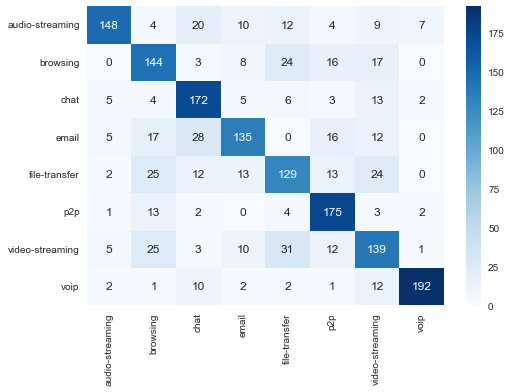

In [28]:
n_df = df_r.copy()
n_df = n_df.drop(['Y', 'YHat', 'Correct'], axis=1)

# n_df.pivot_table(index='label', columns='prediction', fill_value=0, aggfunc=np.sum)
cf = sklearn.metrics.confusion_matrix(df_r['label'], df_r['prediction'])
sns.heatmap(cf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

<AxesSubplot:>

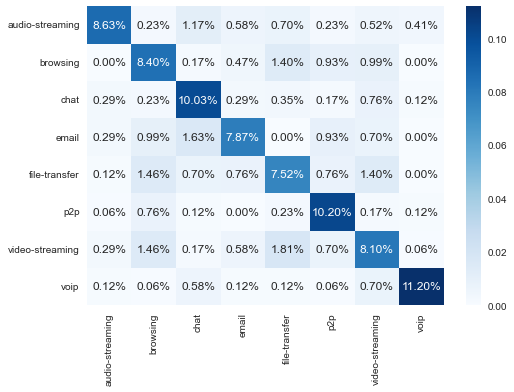

In [29]:
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes, cmap='Blues')


# Setting up a more complex model: Resnet for Tabular Data

In [30]:
y_range     = None
epochs      = 10
classes     = data.classes
cardinality = [1 for _ in range(10)]
layers      = [100 for _ in range(10)]
n_out       = get_c(data.dls)
emb_szs     = get_emb_sz(data.dls.train_ds)


model       = ResidualTabularModel(emb_szs, len(data.dls.cont_names), n_out, layers, y_range=y_range, cardinality=cardinality)
criterion   = nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(model.parameters(), lr=0.01)

Layer sizes: [64, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 8], length: 12
Number of residual blocks: 9
Residual locations:  [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [31]:
X_train = torch.LongTensor(data.X_train.values)
X_test = torch.LongTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)

In [32]:
# losses = []

# for i in range(epochs):
#     y_pred = model.forward(X_train)
#     loss = criterion(y_pred, y_train)
#     losses.append(loss)
#     print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# # preds = []
# # with torch.no_grad():
# #     for val in X_test:
# #         y_hat = model.forward(val)
# #         preds.append(y_hat.argmax().item())

In [33]:
@delegates(Learner.__init__)
def residual_tabular_learner(dls, layers=None, emb_szs=None, config=None, n_out=None, y_range=None, cardinality=None, ps=None, **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    if layers is None: layers = [200,100]
    to = dls.train_ds
    emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = ResidualTabularModel(emb_szs, len(dls.cont_names), n_out, layers, y_range=y_range, cardinality=cardinality, ps=ps, **config)
    return TabularLearner(dls, model, **kwargs)

In [34]:
learner = residual_tabular_learner(data.dls, layers=layers, cardinality=cardinality, n_out=get_c(data.dls), metrics=[accuracy, F1Score(average='macro')])

Layer sizes: [64, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 8], length: 12
Number of residual blocks: 9
Residual locations:  [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [35]:
with learner.no_bar():
    learner.fit_one_cycle(epochs)
    

[0, 2.413553476333618, 1.8745434284210205, 0.4518950581550598, 0.44461832172076293, '00:01']
[1, 1.5238279104232788, 1.3444130420684814, 0.565597653388977, 0.5674219609923816, '00:01']
[2, 1.2412947416305542, 1.1871814727783203, 0.6204081773757935, 0.6202912031697454, '00:01']
[3, 1.097672939300537, 1.1163400411605835, 0.627988338470459, 0.6274112607826449, '00:01']
[4, 1.035822868347168, 1.0653371810913086, 0.6518950462341309, 0.6495542501896152, '00:01']
[5, 1.0009077787399292, 1.0520555973052979, 0.6507288813591003, 0.6497622646390618, '00:01']
[6, 0.9707745909690857, 1.0268892049789429, 0.6524781584739685, 0.6525814502897201, '00:01']
[7, 0.9409072995185852, 1.0222489833831787, 0.6629737615585327, 0.6620740027299934, '00:01']
[8, 0.9209998250007629, 1.0164306163787842, 0.6676384806632996, 0.6681165578491619, '00:01']
[9, 0.9124163389205933, 1.012479305267334, 0.6653061509132385, 0.6644899636417312, '00:01']


(#3) [1.012479305267334,0.6653061509132385,0.6644899636417312]

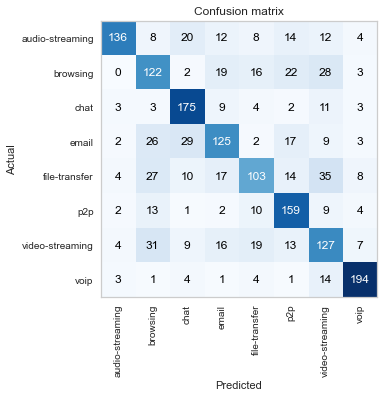

In [36]:
with learner.no_bar():
    results = learner.validate()
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()

results

In [37]:
from fastai.torch_core import Enum



NormType = Enum('NormType', 'Batch BatchZero Weight Spectral Instance InstanceZero')

def _get_norm(prefix, nf, ndim=2, zero=False, **kwargs):
    "Norm layer with `nf` features and `ndim` initialized depending on `norm_type`."
    assert 1 <= ndim <= 3
    bn = getattr(nn, f"{prefix}{ndim}d")(nf, **kwargs)
    if bn.affine:
        bn.bias.data.fill_(1e-3)
        bn.weight.data.fill_(0. if zero else 1.)
    return bn
    
@delegates(nn.BatchNorm2d)
def BatchNorm(nf, ndim=2, norm_type=NormType.Batch, **kwargs):
    "BatchNorm layer with `nf` features and `ndim` initialized depending on `norm_type`."
    return _get_norm('BatchNorm', nf, ndim, zero=norm_type==NormType.BatchZero, **kwargs)



class LinBnDrop(nn.Sequential):
    "Module grouping `BatchNorm1d`, `Dropout` and `Linear` layers"
    def __init__(self, n_in, n_out, bn=True, p=0., act=nn.ReLU(inplace=True), lin_first=False):
        layers = [BatchNorm(n_out if lin_first else n_in, ndim=1)] if bn else []
        if p != 0: layers.append(nn.Dropout(p))
        lin = [nn.Linear(n_in, n_out, bias=not bn)]
        if act is not None: lin.append(act)
        layers = lin+layers if lin_first else layers+lin
        super().__init__(*layers)

In [38]:
class Simple_Resnet_Model(nn.Module):
    def __init__(self, input_features=62, layers=[100 for _ in range(20)], output_features=8):
        super().__init__()
        self._layers = []
        _activations = [nn.ReLU(inplace=True) for _ in range(len(layers) - 1)] + [None]
        # _activations = [nn.ReLU(inplace=True) for _ in range(len(layers))]
        # _activations = [nn.ReLU(inplace=True)] * len(layers)



        for i, x in enumerate(layers):
            print(i)
            if (i == 0):
                print(f'i = {i} == 0')
                self._layers.append(BottleneckResidualBlock([LinBnDrop(input_features, layers[i+1], act=_activations[i], lin_first=True)], i, input_features, layers[i+1]))
            elif (i == len(layers) - 1):
                print(f'i = {i} == {len(layers) - 1}')
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, output_features, act=_activations[i], lin_first=True)], i, x, output_features))
                # self._layers.append(LinBnDrop(x, output_features, act=_activations[i], lin_first=True))
            else:
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, layers[i+1], act=_activations[i], lin_first=True)], i, x, layers[i+1]))
        


        self.out = nn.Sequential(*self._layers)     
        
    def forward(self, x):
        # for i, layer in enumerate(self._layers):
            # print('layer', i)
            # x = layer(x)

        return self.out(x)




In [39]:
epochs    = 10
classes   = data.classes
model     = Simple_Resnet_Model(input_features=62, output_features=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# model

0
i = 0 == 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
i = 19 == 19


In [40]:
X_train = torch.FloatTensor(data.X_train.values)
X_test = torch.FloatTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)

In [41]:
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch:  0  loss: 2.45397043
epoch:  1  loss: 2.05588365
epoch:  2  loss: 1.86561584
epoch:  3  loss: 1.77750444
epoch:  4  loss: 1.71253788
epoch:  5  loss: 1.64287138
epoch:  6  loss: 1.58868003
epoch:  7  loss: 1.54764700
epoch:  8  loss: 1.49339318
epoch:  9  loss: 1.44698215


In [42]:

preds = []
with torch.no_grad():

    predictions = model.forward(X_test)
    preds = predictions.argmax(dim=1).numpy()


In [43]:
df_r = pd.DataFrame({'Y': y_test, 'YHat': preds})
df_r['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df_r['Y'], df_r['YHat'])]
df_r['label'] = df_r['Y'].apply(lambda x: classes[x])
df_r['prediction'] = df_r['YHat'].apply(lambda x: classes[x])

In [44]:
df_r['Correct'].sum() / len(df_r)

0.5212827988338192

<AxesSubplot:>

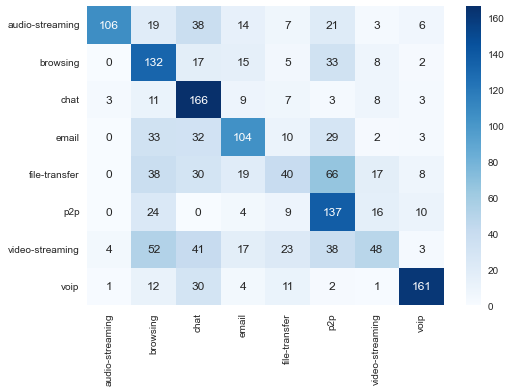

In [45]:
n_df = df_r.copy()
n_df = n_df.drop(['Y', 'YHat', 'Correct'], axis=1)

# n_df.pivot_table(index='label', columns='prediction', fill_value=0, aggfunc=np.sum)
cf = sklearn.metrics.confusion_matrix(df_r['label'], df_r['prediction'])
sns.heatmap(cf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

In [46]:
import spdlayers
import rff

In [47]:
X_train.shape

torch.Size([6861, 62])

In [48]:
encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=62, encoded_size=62)

In [49]:
Xp = encoding(X_train)

In [50]:
Xp.shape

torch.Size([6861, 124])

In [51]:



class BnReluLin(nn.Sequential):
    "Module grouping `BatchNorm1d`, `Relu` and `Linear` layers"
    def __init__(self, n_in, n_out, act=nn.ReLU(inplace=True)):
        layers = [
            BatchNorm(n_in, ndim=1),
            act,
            nn.Linear(n_in, n_out, bias=False)
        ]
        super().__init__(*layers)


In [52]:
class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        self.linear = LinBnDrop(in_size, out_size, lin_first=True, act=nn.ReLU(inplace=True))
        # self.linear = BnReluLin(in_size, out_size)

    def forward(self, inputs):
        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.linear(inputs)
        return fx + inputs



In [53]:

# class ResNet_MLP(nn.Module):

class ResNet_MLP(Module):
    def __init__(self, input_features=62, output_features=8, config={'layers': [100 for _ in range(20)], 'cardinality':[1 for _ in range(20)]}):
        # super().__init__()

        cardinality  = config['cardinality']
        layers       = config['layers']
        _layers = []

        for i, x in enumerate(layers):
            if (i == 0):
                _layers.append(
                    BottleneckResidualBlock(
                        [   
                            BnReluLin(2*(input_features//2), layers[i+1]) for _ in range(cardinality[i])
                        ], 
                        i,
                        input_features, 
                        layers[i+1]
                    )
                )
            elif (i == len(layers) - 1):
                # _layers.append(BottleneckResidualBlock(
                #     [
                #         BnReluLin(x, output_features)
                #     ], 
                #     i, x, output_features)
                # )

                _layers.append(BnReluLin(x, output_features))
                # _layers.append(LinBnDrop(x, output_features))
            else:
                _layers.append(
                    BottleneckResidualBlock(
                        [
                            BnReluLin(x, layers[i+1]) for _ in range(cardinality[i])
                        ], 
                        i, 
                        x, 
                        layers[i+1]
                    )
                )

        self.layers = nn.Sequential(*_layers)     
        
    def forward(self, x):
        return self.layers(x)




In [54]:
class Torch_Model_Loader(Module):
    "Loads a torch model and allows use of the fastai scheduler and optimizer"
    def __init__(self, emb_szs, n_cont, out_sz, model=None, embed_p=0., y_range=None, bn_cont=True, config={'layers': [100 for _ in range(20)], 'cardinality':[1 for _ in range(20)]}):
    
        # setup for the model using Fastai's system of embedding categorical features
    
        self.embeds   = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont  = nn.BatchNorm1d(n_cont) if bn_cont else None
        self.n_emb    = sum(e.embedding_dim for e in self.embeds)
        self.in_sz    = self.n_emb + n_cont
        self.n_cont   = n_cont
        
        
        if(model == None):
            model = ResNet_MLP
        self.model = model(input_features=self.in_sz, output_features=out_sz, config=config)


        _layers: list = []
        _layers.append(self.model)


        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.loader = nn.Sequential(*_layers)



    def forward(self, x_cat, x_cont=None):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        return self.loader(x)


In [55]:
@delegates(Learner.__init__)
def torch_learner(dls, model=None, emb_szs=None, n_out=None, config={'layers': [100 for _ in range(20)], 'cardinality':[1 for _ in range(20)]}, y_range=None, **kwargs):
    '''
        Creates a Fastai Learner using a dataloader and passed in model 
            model parameters are passed in through config
            Tabular learner parameters are passed in as additional kwargs
    
        returns a Fastai TabularModel created using the remaining params
    '''
    emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
    if n_out is None: 
        n_out = get_c(dls)
    
    # option to scale outputs to a certain range, uses a sigmoid function
    # if y_range is None and 'y_range' in config: 
    #     y_range = config.pop('y_range')

    md = Torch_Model_Loader(emb_szs, len(dls.cont_names), n_out, config=config, y_range=y_range, model=model)

    return TabularLearner(dls, md, **kwargs)

In [56]:
new_to = TabularDataLoaders.from_df(balanced_df_1, cat_names=['Protocol'], y_names='Application Type')

In [57]:
new_to.xs.head()

,Protocol,Bwd IAT Std,Fwd IAT Total,Fwd Header Length,RST Flag Count,Fwd IAT Max,Bwd Packet Length Max,Flow Packets/s,Bwd IAT Mean,Flow Duration,Bwd Bulk Rate Avg,Subflow Fwd Bytes,Subflow Bwd Bytes,Fwd IAT Std,Flow Bytes/s,ACK Flag Count,Fwd Segment Size Avg,Idle Mean,Bwd Packets/s,Fwd Packet Length Std,Total Length of Fwd Packet,Subflow Fwd Packets,FWD Init Win Bytes,Bwd Header Length,SYN Flag Count,Packet Length Std,Packet Length Mean,Packet Length Max,Total Length of Bwd Packet,Bwd Segment Size Avg,Idle Min,Flow IAT Std,Bwd Packet Length Min,Flow IAT Min,Bwd Packet Length Mean,Bwd IAT Max,Total Fwd Packet,Average Packet Size,Fwd Packet Length Min,Fwd Packets/s,Fwd PSH Flags,Bwd Packet Length Std,Flow IAT Mean,FIN Flag Count,Fwd IAT Mean,Fwd Packet Length Max,Idle Max,Idle Std,Bwd Init Win Bytes,Bwd Packet/Bulk Avg,Packet Length Min,PSH Flag Count,Total Bwd packets,Down/Up Ratio,Flow IAT Max,Fwd IAT Min,Packet Length Variance,Fwd Act Data Pkts,Fwd Seg Size Min,Bwd IAT Total,Fwd Packet Length Mean,Bwd IAT Min
5076,17,0.000,0,8,0,0,51,4.298921,0.00000,465233,0,17,25,0.000000,184.853607,0,35.00000,0.000000e+00,2.149461,0.000000,35,0,0,8,0,9.237604,40.333332,51,51,51.000000,0.000000e+00,0.000000,51,465233,51.000000,0,1,60.500000,35,2.149461,0,0.00000,465233.000000,0,0.0,35,0.000000e+00,0.0000,0,0,35,0,1,1,465233,0,85.333336,0,8,0,35.00000,0
8435,17,0.000,412246,16,0,412246,0,4.851472,0.00000,412246,0,22,0,0.000000,106.732391,0,22.00000,0.000000e+00,0.000000,0.000000,44,1,0,0,0,0.000000,22.000000,22,0,0.000000,0.000000e+00,0.000000,0,412246,0.000000,0,2,33.000000,22,4.851472,0,0.00000,412246.000000,0,412246.0,22,0.000000e+00,0.0000,0,0,22,0,0,0,412246,412246,0.000000,1,8,0,22.00000,0
6111,6,0.000,201200,40,0,201200,0,9.940358,0.00000,201200,0,0,0,0.000000,0.000000,2,0.00000,0.000000e+00,0.000000,0.000000,0,1,1674,0,0,0.000000,0.000000,0,0,0.000000,0.000000e+00,0.000000,0,201200,0.000000,0,2,0.000000,0,9.940358,0,0.00000,201200.000000,1,201200.0,0,0.000000e+00,0.0000,0,0,0,0,0,0,201200,201200,0.000000,0,20,0,0.00000,0
4907,6,0.000,0,20,0,0,0,4310.344727,0.00000,464,0,0,0,0.000000,0.000000,2,0.00000,0.000000e+00,2155.172363,0.000000,0,0,11680,20,0,0.000000,0.000000,0,0,0.000000,0.000000e+00,0.000000,0,464,0.000000,0,1,0.000000,0,2155.172363,0,0.00000,464.000000,1,0.0,0,0.000000e+00,0.0000,913,0,0,0,1,1,464,0,0.000000,0,20,0,0.00000,0
3846,6,121961.125,2065662,424,0,650732,238,14.103776,121357.46875,2197993,1071,42,28,175840.828125,1005.007751,30,102.46154,1.433770e+15,8.189289,162.109848,1332,0,29200,584,2,115.228378,69.031250,517,877,48.722221,1.433770e+15,104110.507812,0,17,48.722221,509318,13,71.258064,0,5.914486,0,63.95385,73266.429688,1,172138.5,517,1.433770e+15,623246.1875,350,19,0,19,18,1,509318,294,13277.580078,10,32,2063077,102.46154,35


In [58]:
df = balanced_df_1

target_label = 'Application Type'
categorical  = ['Protocol']
leave_out    = []

categorical_features: list = []
untouched_features  : list = []


for x in leave_out:
    if x in df.columns:
        untouched_features.append(x)

for x in categorical:
    if x in df.columns:
        categorical_features.append(x)


continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))


splits = RandomSplitter(valid_pct=.2, seed=seed)(range_of(df))


# The dataframe is loaded into a fastai datastructure now that 
# the feature engineering pipeline has been set up
to = TabularPandas(
    df            , y_names=target_label                , 
    splits=splits , cat_names=categorical_features ,
    cont_names=continuous_features , 
)
to.xs.head()

,Protocol,Bwd IAT Std,Fwd IAT Total,Fwd Header Length,RST Flag Count,Fwd IAT Max,Bwd Packet Length Max,Flow Packets/s,Bwd IAT Mean,Flow Duration,Bwd Bulk Rate Avg,Subflow Fwd Bytes,Subflow Bwd Bytes,Fwd IAT Std,Flow Bytes/s,ACK Flag Count,Fwd Segment Size Avg,Idle Mean,Bwd Packets/s,Fwd Packet Length Std,Total Length of Fwd Packet,Subflow Fwd Packets,FWD Init Win Bytes,Bwd Header Length,SYN Flag Count,Packet Length Std,Packet Length Mean,Packet Length Max,Total Length of Bwd Packet,Bwd Segment Size Avg,Idle Min,Flow IAT Std,Bwd Packet Length Min,Flow IAT Min,Bwd Packet Length Mean,Bwd IAT Max,Total Fwd Packet,Average Packet Size,Fwd Packet Length Min,Fwd Packets/s,Fwd PSH Flags,Bwd Packet Length Std,Flow IAT Mean,FIN Flag Count,Fwd IAT Mean,Fwd Packet Length Max,Idle Max,Idle Std,Bwd Init Win Bytes,Bwd Packet/Bulk Avg,Packet Length Min,PSH Flag Count,Total Bwd packets,Down/Up Ratio,Flow IAT Max,Fwd IAT Min,Packet Length Variance,Fwd Act Data Pkts,Fwd Seg Size Min,Bwd IAT Total,Fwd Packet Length Mean,Bwd IAT Min
5198,6,19603.121094,90132107,60,0,45079385,0,0.066568,45065988.0,90132981,0,0,0,18853.587891,0.000000,6,0.000000,1.438010e+15,0.033284,0.000000,0,0,2190,60,0,0.000000,0.000000,0,0,0.0,1.438010e+15,2.468289e+07,0,408,0.0,45079851,3,0.000000,0,0.033284,0,0.000000,1.802660e+07,0,45066052.0,0,1.438010e+15,3.679554e+07,1183,0,0,0,3,1,45078977,45052722,0.000000,0,20,90131979,0.000000,45052128
8488,0,0.000000,83980981,0,0,41996476,0,0.035722,0.0,83980981,0,0,0,8464.775391,0.000000,0,0.000000,7.161570e+14,0.000000,0.000000,0,1,0,0,0,0.000000,0.000000,0,0,0.0,4.199648e+07,8.464775e+03,0,41984505,0.0,0,3,0.000000,0,0.035722,0,0.000000,4.199049e+07,0,41990492.0,0,1.432310e+15,1.012800e+15,0,0,0,0,0,0,41996476,41984505,0.000000,0,0,0,0.000000,0
3522,17,0.000000,69,16,0,69,53,10.129685,98287.0,394879,415,18,22,0.000000,415.317108,0,37.000000,1.436800e+15,5.064843,0.000000,74,0,0,16,0,7.155417,40.200001,53,90,45.0,1.436800e+15,1.510128e+05,37,69,45.0,98287,2,50.250000,37,5.064843,0,11.313708,1.316263e+05,0,69.0,37,1.436800e+15,1.401252e+05,0,4,37,0,2,1,296523,69,51.200001,1,8,98287,37.000000,98287
5727,6,554694.875000,785107,72,0,784674,0,7.637465,392604.5,785601,0,11,0,554542.125000,86.557938,5,22.666666,1.456270e+15,3.818733,39.259819,68,0,14600,72,2,25.701584,9.714286,68,0,0.0,1.456270e+15,3.508133e+05,0,41,0.0,784833,3,11.333333,0,3.818733,0,0.000000,1.571202e+05,1,392553.5,68,1.456270e+15,4.530872e+05,913,0,0,1,3,1,784674,433,660.571411,1,20,785209,22.666666,376
2508,17,0.000000,0,8,0,0,225,16.004610,0.0,124964,0,18,112,0.000000,2096.603760,0,37.000000,0.000000e+00,8.002305,0.000000,37,0,0,8,0,108.541847,99.666664,225,225,225.0,0.000000e+00,0.000000e+00,225,124964,225.0,0,1,149.500000,37,8.002305,0,0.000000,1.249640e+05,0,0.0,37,0.000000e+00,0.000000e+00,0,0,37,0,1,1,124964,0,11781.333008,0,8,0,37.000000,0


In [59]:
to.procs = data.to.procs
to.xs.head()

,Protocol,Bwd IAT Std,Fwd IAT Total,Fwd Header Length,RST Flag Count,Fwd IAT Max,Bwd Packet Length Max,Flow Packets/s,Bwd IAT Mean,Flow Duration,Bwd Bulk Rate Avg,Subflow Fwd Bytes,Subflow Bwd Bytes,Fwd IAT Std,Flow Bytes/s,ACK Flag Count,Fwd Segment Size Avg,Idle Mean,Bwd Packets/s,Fwd Packet Length Std,Total Length of Fwd Packet,Subflow Fwd Packets,FWD Init Win Bytes,Bwd Header Length,SYN Flag Count,Packet Length Std,Packet Length Mean,Packet Length Max,Total Length of Bwd Packet,Bwd Segment Size Avg,Idle Min,Flow IAT Std,Bwd Packet Length Min,Flow IAT Min,Bwd Packet Length Mean,Bwd IAT Max,Total Fwd Packet,Average Packet Size,Fwd Packet Length Min,Fwd Packets/s,Fwd PSH Flags,Bwd Packet Length Std,Flow IAT Mean,FIN Flag Count,Fwd IAT Mean,Fwd Packet Length Max,Idle Max,Idle Std,Bwd Init Win Bytes,Bwd Packet/Bulk Avg,Packet Length Min,PSH Flag Count,Total Bwd packets,Down/Up Ratio,Flow IAT Max,Fwd IAT Min,Packet Length Variance,Fwd Act Data Pkts,Fwd Seg Size Min,Bwd IAT Total,Fwd Packet Length Mean,Bwd IAT Min
5198,6,19603.121094,90132107,60,0,45079385,0,0.066568,45065988.0,90132981,0,0,0,18853.587891,0.000000,6,0.000000,1.438010e+15,0.033284,0.000000,0,0,2190,60,0,0.000000,0.000000,0,0,0.0,1.438010e+15,2.468289e+07,0,408,0.0,45079851,3,0.000000,0,0.033284,0,0.000000,1.802660e+07,0,45066052.0,0,1.438010e+15,3.679554e+07,1183,0,0,0,3,1,45078977,45052722,0.000000,0,20,90131979,0.000000,45052128
8488,0,0.000000,83980981,0,0,41996476,0,0.035722,0.0,83980981,0,0,0,8464.775391,0.000000,0,0.000000,7.161570e+14,0.000000,0.000000,0,1,0,0,0,0.000000,0.000000,0,0,0.0,4.199648e+07,8.464775e+03,0,41984505,0.0,0,3,0.000000,0,0.035722,0,0.000000,4.199049e+07,0,41990492.0,0,1.432310e+15,1.012800e+15,0,0,0,0,0,0,41996476,41984505,0.000000,0,0,0,0.000000,0
3522,17,0.000000,69,16,0,69,53,10.129685,98287.0,394879,415,18,22,0.000000,415.317108,0,37.000000,1.436800e+15,5.064843,0.000000,74,0,0,16,0,7.155417,40.200001,53,90,45.0,1.436800e+15,1.510128e+05,37,69,45.0,98287,2,50.250000,37,5.064843,0,11.313708,1.316263e+05,0,69.0,37,1.436800e+15,1.401252e+05,0,4,37,0,2,1,296523,69,51.200001,1,8,98287,37.000000,98287
5727,6,554694.875000,785107,72,0,784674,0,7.637465,392604.5,785601,0,11,0,554542.125000,86.557938,5,22.666666,1.456270e+15,3.818733,39.259819,68,0,14600,72,2,25.701584,9.714286,68,0,0.0,1.456270e+15,3.508133e+05,0,41,0.0,784833,3,11.333333,0,3.818733,0,0.000000,1.571202e+05,1,392553.5,68,1.456270e+15,4.530872e+05,913,0,0,1,3,1,784674,433,660.571411,1,20,785209,22.666666,376
2508,17,0.000000,0,8,0,0,225,16.004610,0.0,124964,0,18,112,0.000000,2096.603760,0,37.000000,0.000000e+00,8.002305,0.000000,37,0,0,8,0,108.541847,99.666664,225,225,225.0,0.000000e+00,0.000000e+00,225,124964,225.0,0,1,149.500000,37,8.002305,0,0.000000,1.249640e+05,0,0.0,37,0.000000e+00,0.000000e+00,0,0,37,0,1,1,124964,0,11781.333008,0,8,0,37.000000,0


In [60]:
to.process()
to.xs.head()


,Protocol,Bwd IAT Std,Fwd IAT Total,Fwd Header Length,RST Flag Count,Fwd IAT Max,Bwd Packet Length Max,Flow Packets/s,Bwd IAT Mean,Flow Duration,Bwd Bulk Rate Avg,Subflow Fwd Bytes,Subflow Bwd Bytes,Fwd IAT Std,Flow Bytes/s,ACK Flag Count,Fwd Segment Size Avg,Idle Mean,Bwd Packets/s,Fwd Packet Length Std,Total Length of Fwd Packet,Subflow Fwd Packets,FWD Init Win Bytes,Bwd Header Length,SYN Flag Count,Packet Length Std,Packet Length Mean,Packet Length Max,Total Length of Bwd Packet,Bwd Segment Size Avg,Idle Min,Flow IAT Std,Bwd Packet Length Min,Flow IAT Min,Bwd Packet Length Mean,Bwd IAT Max,Total Fwd Packet,Average Packet Size,Fwd Packet Length Min,Fwd Packets/s,Fwd PSH Flags,Bwd Packet Length Std,Flow IAT Mean,FIN Flag Count,Fwd IAT Mean,Fwd Packet Length Max,Idle Max,Idle Std,Bwd Init Win Bytes,Bwd Packet/Bulk Avg,Packet Length Min,PSH Flag Count,Total Bwd packets,Down/Up Ratio,Flow IAT Max,Fwd IAT Min,Packet Length Variance,Fwd Act Data Pkts,Fwd Seg Size Min,Bwd IAT Total,Fwd Packet Length Mean,Bwd IAT Min
5198,2,-0.301810,1.818737,-0.113079,-0.198295,2.291798,-0.506906,-0.209408,5.008667,1.788637,-0.073634,-0.319533,-0.538974,-0.327201,-0.267903,-0.118194,-0.388934,1.146977,-0.165531,-0.461306,-0.075939,-0.529185,-0.310961,-0.107789,-0.495637,-0.680873,-0.554040,-0.527928,-0.079563,-0.598605,1.251504,3.623793,-0.520597,-0.139646,-0.598605,2.553649,-0.122685,-0.621408,-0.568059,-0.217004,-0.329786,-0.421620,2.822217,-0.736129,4.274848,-0.416031,1.098600,-0.232513,-0.156020,-0.125253,-0.608155,-0.132614,-0.127631,0.277204,2.256641,4.761077,-0.463906,-0.098720,0.546388,1.919829,-0.388934,5.883356
8488,1,-0.305374,1.659648,-0.114163,-0.198295,2.104391,-0.506906,-0.209409,-0.271386,1.630728,-0.073634,-0.319533,-0.538974,-0.329029,-0.267903,-0.119518,-0.388934,0.120767,-0.165532,-0.461306,-0.075939,1.889696,-0.476973,-0.108861,-0.495637,-0.680873,-0.554040,-0.527928,-0.079563,-0.598605,-0.795204,-0.378541,-0.520597,9.359523,-0.598605,-0.393673,-0.122685,-0.621408,-0.568059,-0.217004,-0.329786,-0.421620,7.002896,-0.736129,3.961141,-0.416031,1.090659,6.164490,-0.255490,-0.125253,-0.608155,-0.132614,-0.128929,-0.533149,2.070558,4.421427,-0.463906,-0.098720,-1.971592,-0.468270,-0.388934,-0.164844
3522,3,-0.305374,-0.512386,-0.113874,-0.198295,-0.448528,-0.409117,-0.209211,-0.259870,-0.514753,-0.072585,-0.225053,-0.374911,-0.330519,-0.266281,-0.119518,-0.235612,1.145257,-0.165316,-0.461306,-0.075914,-0.529185,-0.476973,-0.108575,-0.495637,-0.642336,-0.376826,-0.450537,-0.079524,-0.405462,1.249782,-0.355419,-0.211079,-0.139723,-0.405462,-0.387247,-0.123073,-0.403892,0.640332,-0.216844,-0.329786,-0.355647,-0.299693,-0.736129,-0.321874,-0.349576,1.096915,-0.232513,-0.255490,-0.123672,0.777141,-0.132614,-0.128063,0.277204,-0.446767,-0.226228,-0.463435,-0.098293,-0.964400,-0.465666,-0.235612,-0.151649
5727,2,-0.204526,-0.492082,-0.112863,-0.198295,-0.400833,-0.506906,-0.209260,-0.225387,-0.504724,-0.073634,-0.261795,-0.538974,-0.232902,-0.267565,-0.118415,-0.295007,1.172936,-0.165369,-0.167719,-0.075916,-0.529185,0.629772,-0.107574,2.001107,-0.542453,-0.511216,-0.428634,-0.079563,-0.598605,1.277493,-0.323010,-0.520597,-0.139729,-0.598605,-0.342361,-0.122685,-0.572350,-0.568059,-0.216884,-0.329786,-0.421620,-0.295245,1.224501,-0.281841,-0.293898,1.124041,-0.232513,-0.178722,-0.125253,-0.608155,-0.131774,-0.127631,0.277204,-0.417299,-0.226188,-0.457833,-0.098293,0.546388,-0.447465,-0.295007,-0.164794
2508,3,-0.305374,-0.512387,-0.114018,-0.198295,-0.448533,-0.091763,-0.209097,-0.271386,-0.521681,-0.073634,-0.225053,0.296257,-0.330519,-0.259716,-0.119518,-0.235612,-0.897345,-0.165191,-0.461306,-0.075926,-0.529185,-0.476973,-0.108718,-0.495637,-0.096306,-0.114679,-0.199381,-0.079466,0.367108,-0.795204,-0.379914,1.361604,-0.111465,0.367108,-0.393673,-0.123462,0.025731,0.640332,-0.216751,-0.329786,-0.421620,-0.300855,-0.736129,-0.321881,-0.349576,-0.904908,-0.232513,-0.255490,-0.125253,0.777141,-0.132614,-0.128496,0.277204,-0.457124,-0.226236

In [61]:
from fastcore.all import camel2snake, noop, mk_transform

In [62]:
def train_deep_model_on_new_df(
    model_data: Model_data,
    df: pd.DataFrame,
    target_label: str, 
    split=0.2, 
    categorical: list = ['Protocol'],
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
    fit_choice: str = 'one_cycle',
    no_bar: bool = False,
) -> Model_data:
    '''
    '''


    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))


    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        cont_names=continuous_features , 
    )

    # loads the transformations from the previous data loaders and applies them to the new data
    # to.procs = model_data.to.procs
    # to.process()

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    learner = residual_tabular_learner(
        dls, 
        layers=[100 for i in range(5)], 
        metrics = metrics,
        cbs=callbacks,
        cardinality=[2 for i in range(5)]
    )

    # config = {'layers': layers, 'cardinality': cardinality, 'enc_sz': 50}
    # learner = residual_tabular_learner(dls, layers=layers)
    # learner = torch_learner(dls, metrics=metrics, cbs=callbacks, config=config)
    # learner.model = model_data.model.model.model

    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = learner.lr_find(suggest_funcs=[valley, slide, steep, minimum])

            # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            learner.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            learner.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'

        learner.recorder.plot_sched() 
        results = learner.validate()
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix()
                

    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')
    learner.save(f'{model_data.name}.model')


    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(learner)

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    new_model_data: Model_data = Model_data(model_data.name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, model_data.model_type)


    return new_model_data



In [84]:


def train_deep_model_on_new_df(
    model_data: Model_data,
    df: pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    shape: tuple, 
    split=0.2, 
    categorical: list = ['Protocol'],
    procs = [FillMissing, Categorify, Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
    fit_choice: str = 'one_cycle',
    cardinality: list or None = None,
    no_bar: bool = False,
) -> Model_data:


    shape = tuple(shape)

    if name is None:
        width: int = shape[0]
        for x in shape:
            width = x if (x > width) else width
        name = f'Residual_1D_Deep_NN_{len(shape)}x{width}'

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    

    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
        do_setup=False,
        # procs=model_data.to.procs   , cont_names=continuous_features , 
    )
    to.procs = model_data.to.procs
    to.process()

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    learner = residual_tabular_learner(
        dls, 
        layers=list(shape), 
        metrics = metrics,
        cbs=callbacks,
        cardinality=cardinality
    )
    learner.model = model_data.model.model.model


    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = learner.lr_find(suggest_funcs=[valley, slide, steep, minimum])

            # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            learner.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            learner.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'

        learner.recorder.plot_sched() 
        results = learner.validate()
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix()
                

    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')
    learner.save(f'{file_name}.model')


    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(learner)

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: Model_data = Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data

Layer sizes: [64, 100, 100, 100, 100, 100, 8], length: 7
Number of residual blocks: 4
Residual locations:  [1, 2, 3, 4]


C:\ProgramData\Anaconda3\lib\site-packages\fastai\callback\schedule.py:270: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.



loss: 0.8211848139762878, accuracy:  73.35%


,epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,0,2.275163,2.161642,0.333528,0.332760,0.661177,0.240383,0.311980,0.313424,0.332760,00:01
1,1,2.004521,1.922178,0.366181,0.366615,0.715841,0.277524,0.352081,0.353718,0.366615,00:01
2,2,1.792512,1.738254,0.418659,0.420305,0.756534,0.338042,0.411178,0.417915,0.420305,00:01
3,3,1.602642,1.587207,0.480466,0.482626,0.797196,0.407998,0.475232,0.478935,0.482626,00:01
4,4,1.461371,1.483282,0.512536,0.515796,0.823351,0.445697,0.508866,0.520761,0.515796,00:01
...,...,...,...,...,...,...,...,...,...,...,...
97,97,0.658908,0.813323,0.719534,0.721462,0.946219,0.680583,0.722668,0.731397,0.721462,00:01
98,98,0.668142,0.825336,0.726531,0.728577,0.945441,0.688716,0.727626,0.735629,0.728577,00:01
99,99,0.668655,0.821185,0.733528,0.735279,0.945212,0.696712,0.736423,0.745388,0.735279,00:01
100,-1,0.000000,0.821185,0.733528,0.735279,0.945212,0.696712,0.736423,0.745388,0.735279,00:00


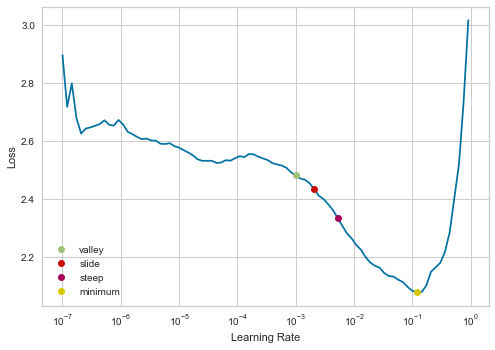

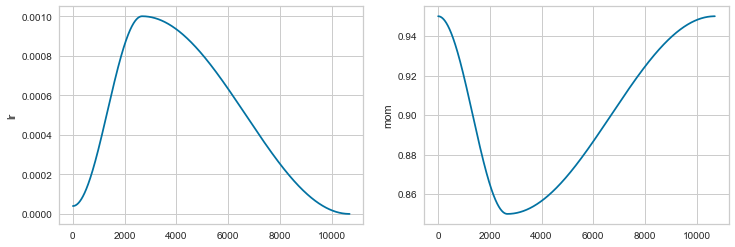

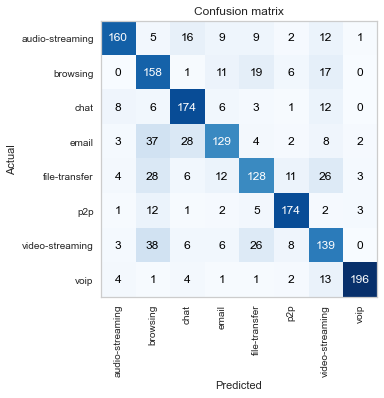

In [105]:
logger_1 = DFLogger()

model_data_1 = run_residual_deep_nn_experiment(
    balanced_df,
    'none.csv',
    'Application Type',
    [100 for i in range(5)],
    epochs=100,
    callbacks=[logger_1],
    no_bar=True,
)
logger_1.df

Layer sizes: [64, 100, 100, 100, 100, 100, 8], length: 7
Number of residual blocks: 4
Residual locations:  [1, 2, 3, 4]


C:\ProgramData\Anaconda3\lib\site-packages\fastai\callback\schedule.py:270: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.



loss: 0.9174367785453796, accuracy:  72.71%


,epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,0,0.641584,0.907314,0.720117,0.721905,0.942801,0.680608,0.721952,0.725012,0.721905,00:01
1,1,0.649702,0.936399,0.704956,0.707104,0.938455,0.663816,0.706702,0.712574,0.707104,00:01
2,2,0.657838,0.896804,0.724198,0.726095,0.944454,0.685183,0.725837,0.727824,0.726095,00:01
3,3,0.643346,0.893161,0.723032,0.724851,0.944157,0.683755,0.724461,0.725968,0.724851,00:01
4,4,0.649312,0.973638,0.691545,0.693626,0.932794,0.648206,0.694399,0.699531,0.693626,00:01
...,...,...,...,...,...,...,...,...,...,...,...
97,97,0.623540,0.903323,0.709038,0.711002,0.942059,0.668424,0.711347,0.717294,0.711002,00:01
98,98,0.623514,0.920312,0.725947,0.727805,0.942029,0.686950,0.727930,0.729149,0.727805,00:01
99,99,0.636100,0.917437,0.727114,0.728983,0.942549,0.688523,0.728961,0.731278,0.728983,00:01
100,-1,0.000000,0.917437,0.727114,0.728983,0.942549,0.688523,0.728961,0.731278,0.728983,00:00


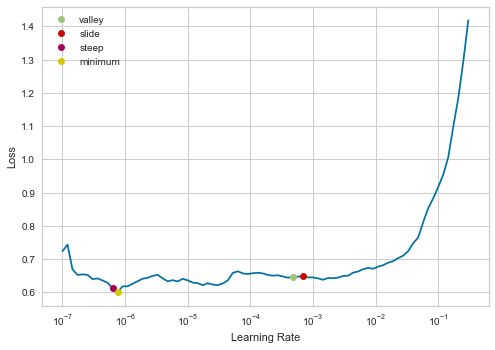

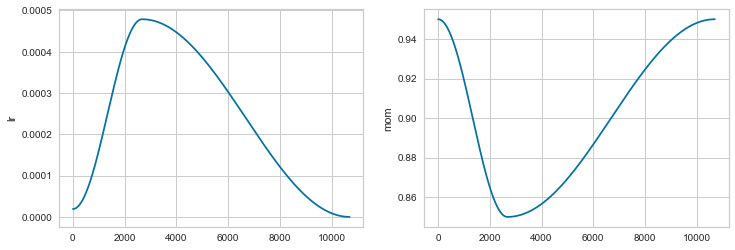

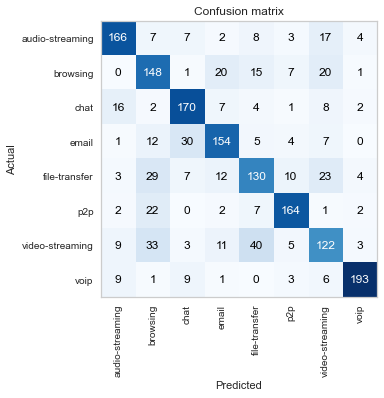

In [109]:
logger_2 = DFLogger()
res = train_deep_model_on_new_df(
    model_data_1, 
    balanced_df_1, 
    'none.csv',
    'Application Type',
    [100 for i in range(5)],
    epochs=100,
    callbacks=[logger_2],
    no_bar=True,
)
    
    
logger_2.df

Layer sizes: [64, 100, 100, 100, 100, 100, 8], length: 7
Number of residual blocks: 4
Residual locations:  [1, 2, 3, 4]


C:\ProgramData\Anaconda3\lib\site-packages\fastai\callback\schedule.py:270: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.



loss: 0.9529487490653992, accuracy:  70.44%


,epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,0,2.203392,2.009981,0.345190,0.344091,0.696674,0.253564,0.321774,0.318260,0.344091,00:01
1,1,1.888789,1.803205,0.408746,0.408714,0.749922,0.326052,0.393704,0.393493,0.408714,00:02
2,2,1.673357,1.622630,0.482799,0.485054,0.796117,0.412331,0.475801,0.487081,0.485054,00:01
3,3,1.501662,1.509604,0.517201,0.520714,0.826074,0.453144,0.512697,0.532467,0.520714,00:01
4,4,1.387515,1.421987,0.541108,0.543120,0.842435,0.477526,0.542974,0.554747,0.543120,00:01
...,...,...,...,...,...,...,...,...,...,...,...
97,97,0.655376,0.910557,0.721283,0.722361,0.940772,0.681780,0.723364,0.726945,0.722361,00:01
98,98,0.646613,0.894163,0.722449,0.723991,0.942382,0.683068,0.724966,0.728145,0.723991,00:01
99,99,0.656817,0.952949,0.704373,0.705395,0.935220,0.662694,0.706191,0.711439,0.705395,00:01
100,-1,0.000000,0.952949,0.704373,0.705395,0.935220,0.662694,0.706191,0.711439,0.705395,00:00


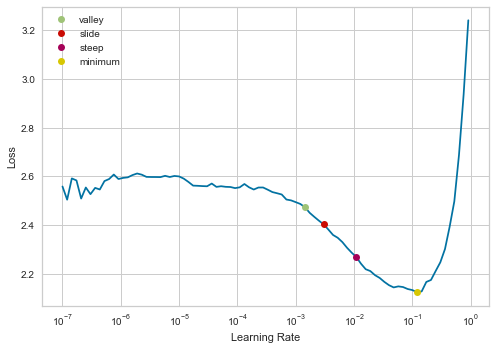

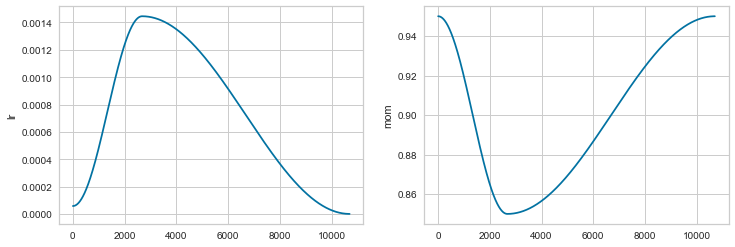

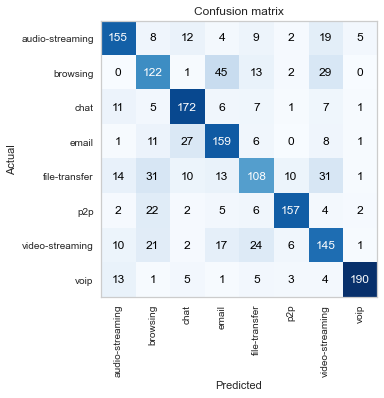

In [107]:
logger_3 = DFLogger()

model_data_3 = run_residual_deep_nn_experiment(
    balanced_df_1,
    'none2.csv',
    'Application Type',
    [100 for i in range(5)],
    epochs=100,
    callbacks=[logger_3],
    no_bar=True,
)
logger_3.df

In [114]:
def downsample_df(df: pd.DataFrame, target_label: str, sample_size: int, seed: int = 14) -> pd.DataFrame:
    """
    Downsample a dataframe to a given sample size
    """

    ndf = df.copy()
    classes = list(ndf.groupby(target_label).size().keys())
    
    outdf = pd.DataFrame()

    for c in classes:
        cdf = ndf[ndf[target_label] == c]
        if (len(cdf) > sample_size):
            cdf = cdf.sample(sample_size, random_state=seed)
        else:
            cdf = cdf.sample(len(cdf), random_state=seed)
        outdf = outdf.append(cdf)

    return outdf

In [116]:
downsample_df(balanced_df, 'Application Type', 5000).shape

(8576, 63)

In [117]:
def reduce_df_to_minority_class(df: pd.DataFrame, target_label: str, seed: int = 14) -> pd.DataFrame:
    """
    Downsample a dataframe to a given sample size
    """

    minority_num = min(df.groupby(target_label).size())

    out = downsample_df(df, target_label, minority_num, seed)

    return out

In [123]:
dataset_1['Dataset'].shape

(141481, 64)

In [124]:
reduce_df_to_minority_class(dataset_1['Dataset'], 'Application Type').shape

(28528, 64)

In [127]:
def continue_training_deep_model(
    model_data: Model_data,
    epochs: int = 10,
    lr_choice: str = 'valley',
    fit_choice: str = 'one_cycle',
    no_bar: bool = False,
) -> Model_data:
    '''
    Function to continue training a deep model in the model_data tuple
    '''

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]

    learner = model_data.model.model

    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = learner.lr_find(suggest_funcs=[valley, slide, steep, minimum])

            # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            learner.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            learner.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'

        learner.recorder.plot_sched() 
        results = learner.validate()
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix()
                

    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')
    learner.save(f'{model_data.name}.model')

    model = model_data.model # confusing, i know, this returns the sklearn wrapper
    model.model = learner    # which then has a .model attribute that is the learner

    out: Model_data = Model_data(model_data.name, model, model_data.classes, model_data.X_train, model_data.y_train, model_data.X_test, model_data.y_test, model_data.to, model_data.dls, model_data.model_type)

    return out

C:\ProgramData\Anaconda3\lib\site-packages\fastai\callback\schedule.py:270: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.



loss: 0.790015459060669, accuracy:  73.00%


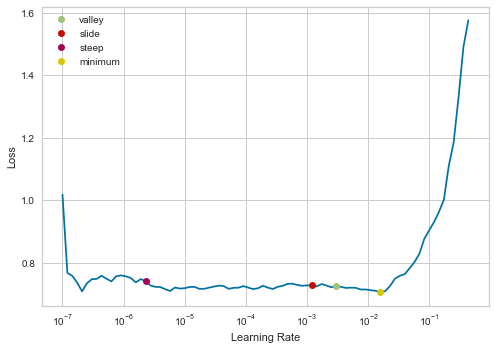

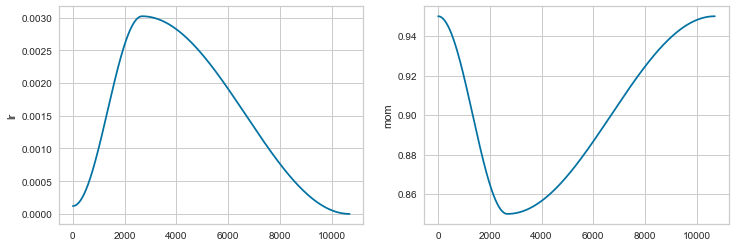

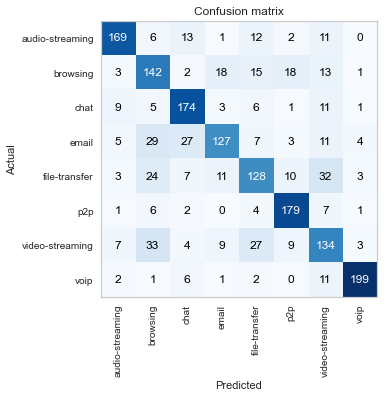

In [129]:
model_data_2 = continue_training_deep_model(model_data_1, epochs=100, no_bar=True)

In [131]:
max(logger_1.df['accuracy'])

0.7562682032585144

C:\ProgramData\Anaconda3\lib\site-packages\fastai\callback\schedule.py:270: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.



loss: 0.7828512191772461, accuracy:  73.12%


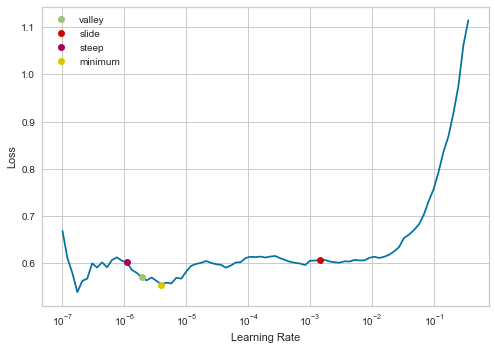

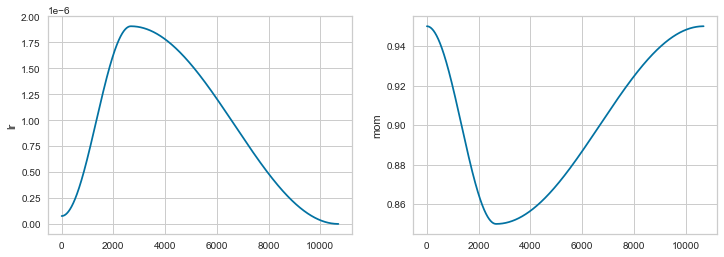

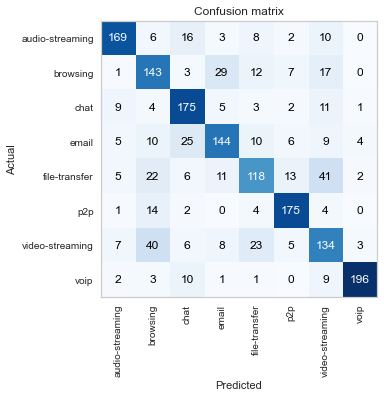

In [132]:
model_data_4 = continue_training_deep_model(model_data_2, epochs=100, no_bar=True)
max(logger_1.df['accuracy'])

In [133]:
max(logger_1.df['accuracy'])

0.7562682032585144

C:\ProgramData\Anaconda3\lib\site-packages\fastai\callback\schedule.py:270: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.



loss: 0.7663182020187378, accuracy:  75.34%


0.7626821994781494

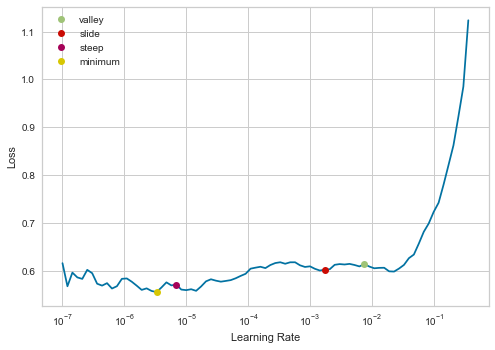

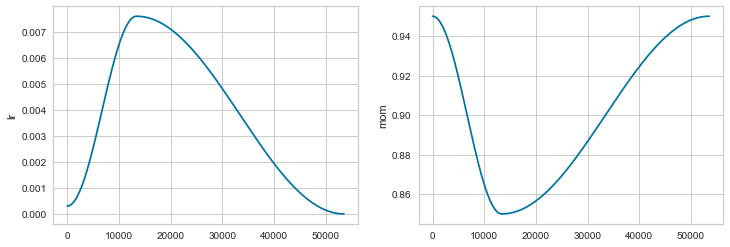

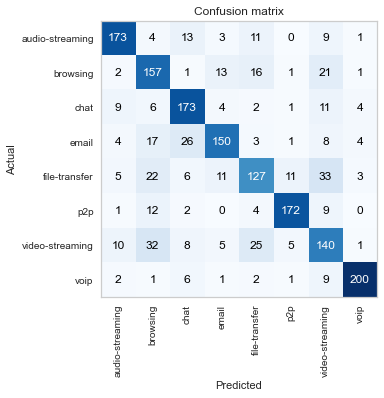

In [135]:
model_data_5 = continue_training_deep_model(model_data_4, epochs=500, no_bar=True)
max(logger_1.df['accuracy'])

In [ ]:
spdlayers.Cholesky(output_shape=10)

In [ ]:
spdlayers.Eigen()

In [136]:
from fastai.vision.models import resnet34

In [137]:
r = resnet34(pretrained=True)

In [ ]:
m = nn.Linear(5,10)

In [ ]:
model_data_1.model.model.model

In [250]:
y_range     = None
epochs      = 20
classes     = data.classes
cardinality = [4 for _ in range(3)]
layers      = [50 for _ in range(3)]
n_out       = get_c(data.dls)
emb_szs     = get_emb_sz(data.dls.train_ds)

logger_1 = DFLogger()
collector_1 = ModelStatsCallback()
grapher_1 = LazyGraphCallback()
# model_saver = SaveModelCallback(monitor='f1_score')
model_saver = SaveModelCallback(monitor='balanced_accuracy_score')
callbacks_1 = [model_saver, logger_1, collector_1, grapher_1]
# callbacks_1 = [logger_1, collector_1, grapher_1]
config = {'layers': layers, 'cardinality': cardinality, 'enc_sz': 50}
metrics=[accuracy, BalancedAccuracy(),  F1Score(average='macro')]
learner = torch_learner(data.dls, metrics=metrics, cbs=callbacks_1, config=config)
learner.model


Torch_Model_Loader(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): ResNet_MLP(
    (layers): Sequential(
      (0): BottleneckResidualBlock(
        (linear): LinBnDrop(
          (0): Linear(in_features=64, out_features=50, bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): BottleneckResidualBlock(
        (linear): LinBnDrop(
          (0): Linear(in_features=50, out_features=50, bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): BnReluLin(
        (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=50, 

Better model found at epoch 0 with balanced_accuracy_score value: 0.23542548854381634.
Better model found at epoch 1 with balanced_accuracy_score value: 0.4201535131930013.
Better model found at epoch 2 with balanced_accuracy_score value: 0.4838165984004704.
Better model found at epoch 3 with balanced_accuracy_score value: 0.5572376497709288.
Better model found at epoch 4 with balanced_accuracy_score value: 0.6007379323818887.
Better model found at epoch 5 with balanced_accuracy_score value: 0.6265773858121975.
Better model found at epoch 6 with balanced_accuracy_score value: 0.6497239438752362.
Better model found at epoch 7 with balanced_accuracy_score value: 0.6554203230209648.
Better model found at epoch 9 with balanced_accuracy_score value: 0.6786550032418444.
Better model found at epoch 13 with balanced_accuracy_score value: 0.6931855390431246.
Better model found at epoch 15 with balanced_accuracy_score value: 0.6959091366388623.
Better model found at epoch 0 with balanced_accurac

(#4) [0.9505032300949097,0.6938775777816772,0.6959091366388623,0.6943647625432894]

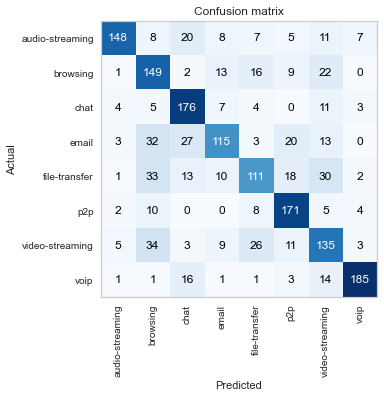

In [251]:
with learner.no_bar():
    learner.fit_one_cycle(epochs)
    results = learner.validate()
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()

results

In [252]:
logger_1.df

,epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0,2.091741,2.058555,0.236735,0.235425,0.209867,00:01
1,1,1.931021,1.865189,0.421574,0.420154,0.403329,00:01
2,2,1.712906,1.655416,0.483382,0.483817,0.482094,00:02
3,3,1.484529,1.465906,0.553936,0.557238,0.549800,00:01
4,4,1.311166,1.297973,0.597085,0.600738,0.593581,00:03
5,5,1.199316,1.184824,0.624490,0.626577,0.625702,00:01
6,6,1.109981,1.112172,0.647230,0.649724,0.647965,00:01
7,7,1.071168,1.081263,0.653061,0.655420,0.654872,00:01
8,8,1.027329,1.055766,0.650729,0.653177,0.651479,00:01
9,9,0.985353,1.013042,0.676385,0.678655,0.676840,00:01


In [253]:
data.dls.encodes()

TypeError: 'L' object is not callable

In [ ]:
dir(data.dls)

In [ ]:
class RFF_Resnet_Model(nn.Module):
    def __init__(self, input_features=62, layers=[100 for _ in range(20)], output_features=8):
        super().__init__()
        self._layers = []
        _activations = [nn.ReLU(inplace=True) for _ in range(len(layers) - 1)] + [None]
    
        for i, layer in enumerate(layers):
            layers[i] = 2*(layer // 2)

        self.ff = rff.layers.GaussianEncoding(sigma=10.0, input_size=input_features, encoded_size=layers[0]//2).to('cpu')


        for i, x in enumerate(layers):
            if (i == 0):
                self._layers.append(BottleneckResidualBlock(
                    [   
                        self.ff,
                        # self.ff,
                        # rff.layers.GaussianEncoding(sigma=10.0, input_size=input_features, encoded_size=layers[i+1]//2),
                        LinBnDrop(2*(input_features//2), layers[i+1], act=_activations[i], lin_first=True)
                    ], i, 2*(input_features//2), layers[i+1]))
            elif (i == len(layers) - 1):
                self._layers.append(BottleneckResidualBlock(
                    [
                        LinBnDrop(x, output_features, act=_activations[i], lin_first=True)
                    ], 
                    i, x, output_features)
                )
                # self._layers.append(LinBnDrop(x, output_features, act=_activations[i], lin_first=True))
            else:
                self._layers.append(BottleneckResidualBlock(
                    [
                        # rff.layers.GaussianEncoding(sigma=10.0, input_size=x, encoded_size=layers[i+1]//2),
                        LinBnDrop(x, layers[i+1], act=_activations[i], lin_first=True)
                    ], 
                    i, x, layers[i+1]
                ))
        


        self.out = nn.Sequential(*self._layers)     
        
    def forward(self, x):
        return self.out(x)




In [ ]:

# class ResNet_MLP(nn.Module):

class RFF_Res_MLP(Module):
    def __init__(self, input_features=62, output_features=8, config={'layers': [100 for _ in range(20)], 'cardinality':[1 for _ in range(20)], 'enc_sz': 20}):
        # super().__init__()

        cardinality  = config['cardinality']
        layers       = config['layers']
        enc_sz       = config['enc_sz']

        self.rff = rff.layers.GaussianEncoding(sigma=10.0, input_size=input_features, encoded_size=enc_sz).to('cpu')

        _layers = []
        _layers.append(Cat([self.rff, Identity()], dim=1))

        for i, x in enumerate(layers):
            if (i == 0):
                _layers.append(
                    BottleneckResidualBlock(
                        [   
                            BnReluLin(2*enc_sz + input_features, layers[i+1]) for _ in range(cardinality[i])
                        ], 
                        i,
                        2*enc_sz + input_features, 
                        layers[i+1]
                    )
                )
            elif (i == len(layers) - 1):
                # _layers.append(BottleneckResidualBlock(
                #     [
                #         BnReluLin(x, output_features)
                #     ], 
                #     i, x, output_features)
                # )

                _layers.append(BnReluLin(x, output_features))
                # _layers.append(LinBnDrop(x, output_features))
            else:
                _layers.append(
                    BottleneckResidualBlock(
                        [
                            BnReluLin(x, layers[i+1]) for _ in range(cardinality[i])
                        ], 
                        i, 
                        x, 
                        layers[i+1]
                    )
                )

        self.layers = nn.Sequential(*_layers)     
        
    def forward(self, x):
        return self.layers(x)




In [ ]:
config = {'layers': layers, 'cardinality': cardinality, 'enc_sz': 30}

In [ ]:
balanced_df.shape

In [ ]:
learner = torch_learner(data.dls, metrics=[accuracy, F1Score(average='macro')], cbs=callbacks_1, config=config, model=RFF_Res_MLP)

In [ ]:
with learner.no_bar():
    learner.fit_one_cycle(epochs)
    results = learner.validate()
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()

results

In [ ]:
logger_1.df

In [ ]:
X_train = torch.FloatTensor(data.X_train.values)
X_test = torch.FloatTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)

In [ ]:
epochs    = 100
classes   = data.classes
model     = RFF_Res_MLP(input_features=62, output_features=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

In [ ]:
epochs    = 100
classes   = data.classes
model     = RFF_Res_MLP(input_features=62, output_features=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []

X_train = torch.FloatTensor(data.X_train.values)
X_test = torch.FloatTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)


for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

preds = []
with torch.no_grad():

    predictions = model.forward(X_test)
    preds = predictions.argmax(dim=1).numpy()


df_r = pd.DataFrame({'Y': y_test, 'YHat': preds})
df_r['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df_r['Y'], df_r['YHat'])]
df_r['label'] = df_r['Y'].apply(lambda x: classes[x])
df_r['prediction'] = df_r['YHat'].apply(lambda x: classes[x])
df_r['Correct'].sum() / len(df_r)

In [ ]:
n_df = df_r.copy()
n_df = n_df.drop(['Y', 'YHat', 'Correct'], axis=1)

# n_df.pivot_table(index='label', columns='prediction', fill_value=0, aggfunc=np.sum)
cf = sklearn.metrics.confusion_matrix(df_r['label'], df_r['prediction'])
sns.heatmap(cf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

In [220]:
from fastai.vision.models import resnet18
from fastai.layers import SimpleCNN

In [139]:
classes   = data.classes
input_features=62
output_features=len(classes)

In [243]:
r = SimpleCNN([3,8,8])
r

SimpleCNN(
  (0): ConvLayer(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): PoolFlatten(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(full=False)
  )
)

In [244]:
class bury_layer(Module):
    def forward(self, x):
        # print(x.shape)

        out = x.view(x.shape[0], 1, *x.shape[1:])
        # Tensor.view
        return out

In [254]:
new_model = model = nn.Sequential(
    nn.Linear(input_features, 105, bias=False),
    nn.ReLU(inplace=True),
    BatchNorm(105, ndim=1),
    Cat(
        [
            nn.Sequential(
                LinBnDrop(105, 105),
                spdlayers.Cholesky(14),
                bury_layer(),
            ),
            nn.Sequential(
                LinBnDrop(105, 105),
                spdlayers.Cholesky(14),
                bury_layer(),
            ),
            nn.Sequential(
                LinBnDrop(105, 105),
                spdlayers.Cholesky(14),
                bury_layer(),
            ),
        ],
        dim=1
    ),
    SimpleCNN([3,8,8]),
)

In [260]:
class SPDTabCNN(Module):
    def __init__(self, input_features=128, output_features=10, config=None):
        self.layers = nn.Sequential(
            nn.Linear(input_features, 105, bias=False),
            nn.ReLU(inplace=True),
            BatchNorm(105, ndim=1),
            Cat(
                [
                    nn.Sequential(
                        LinBnDrop(105, 105),
                        spdlayers.Cholesky(14),
                        bury_layer(),
                    ),
                    nn.Sequential(
                        LinBnDrop(105, 105),
                        spdlayers.Cholesky(14),
                        bury_layer(),
                    ),
                    nn.Sequential(
                        LinBnDrop(105, 105),
                        spdlayers.Cholesky(14),
                        bury_layer(),
                    ),
                    nn.Sequential(
                        LinBnDrop(105, 105),
                        spdlayers.Cholesky(14),
                        bury_layer(),
                    ),
                    nn.Sequential(
                        LinBnDrop(105, 105),
                        spdlayers.Cholesky(14),
                        bury_layer(),
                    ),
                    nn.Sequential(
                        LinBnDrop(105, 105),
                        spdlayers.Cholesky(14),
                        bury_layer(),
                    ),
                    nn.Sequential(
                        LinBnDrop(105, 105),
                        spdlayers.Cholesky(14),
                        bury_layer(),
                    ),
                    nn.Sequential(
                        LinBnDrop(105, 105),
                        spdlayers.Cholesky(14),
                        bury_layer(),
                    ),
                ],
                dim=1
            ),
            SimpleCNN([8,8,output_features]),
        )

    def forward(self, x):
        return self.layers(x)

In [292]:
temp = model(X_train[0:64])

In [293]:
temp.shape

torch.Size([64, 8])

In [307]:
import torch
from functools import reduce

class DNDT(torch.nn.Module):
    def __init__(self, n_features, n_cuts, n_classes,temperature):
        super(DNDT, self).__init__()
        self.n_bins = n_cuts+1
        self.n_cuts = n_cuts
        self.beta = torch.rand(self.n_cuts)
        self.leaves2classes = torch.rand(tuple([self.n_bins**n_features,n_classes]))
        self.leaves2classes.requires_grad = True
        self.beta.requires_grad = True
        self.temperature = temperature
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    def pi_maker(feature,beta,temperature=0.1):
        n_bins = len(beta)
        w = torch.reshape(torch.linspace(1,n_bins,n_bins),[-1,1]) #make constant or something later
        torch.Variable(w, requires_grad=False)
        beta, _ = torch.sort(beta)
        beta[0] = 0
        b = torch.cumsum(-beta,0)
        pi = torch.reshape(torch.softmax((w*feature+b)/temperature,0),[-1,1])
        return pi
    
    def beta2b(self):
        beta, _ = torch.sort(self.beta)
        b = torch.cumsum(-beta,0)
        return torch.cat([torch.zeros(1), b], 0).double()
         
    def forward(self, x):

        x = x.unsqueeze(2).to(self.device)
        w = torch.reshape(torch.linspace(1,self.n_bins,self.n_bins),[1,-1]).to(self.device).float()
        b = self.beta2b().to(self.device)
        xw = torch.matmul(x,w)
        
        sigma = torch.sigmoid((xw+b)/self.temperature)
        leaves = torch.zeros((sigma.size(0),sigma.size(2)**sigma.size(1)))
        for i,sample in enumerate(sigma):
            feature_list = [feature.unsqueeze(1) for feature in sample]
            leaves[i] = reduce(kronecker,feature_list).squeeze(1)
        
        y_pred = leaves@self.leaves2classes
        
        return y_pred

def kronecker(A, B):
    return torch.einsum("ab,cd->acbd", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1))

In [308]:
deepDT = DNDT(n_features=input_features, n_cuts=1, n_classes=8, temperature=0.1)

In [309]:
temp = deepDT(X_train[0:32])

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 34359738368 bytes.

In [283]:
deepDT = DNDT(n_features=input_features, n_cuts=5, n_classes=8, temperature=0.1)

TypeError: rand(): argument 'size' must be tuple of ints, but found element of type int at pos 1

In [302]:
def torch_kron_prod(a, b):
    res = torch.einsum('ij,ik->ijk', [a, b])
    res = torch.reshape(res, [-1, np.prod(res.shape[1:])])
    return res



def torch_bin(x, cut_points, temperature=0.1):
    # x is a N-by-1 matrix (column vector)
    # cut_points is a D-dim vector (D is the number of cut-points)
    # this function produces a N-by-(D+1) matrix, each row has only one element being one and the rest are all zeros
    D = cut_points.shape[0]
    W = torch.reshape(torch.linspace(1.0, D + 1.0, D + 1), [1, -1])
    cut_points, _ = torch.sort(cut_points)  # make sure cut_points is monotonically increasing
    b = torch.cumsum(torch.cat([torch.zeros([1]), -cut_points], 0),0)
    h = torch.matmul(x, W) + b
    res = torch.exp(h-torch.max(h))
    res = res/torch.sum(res, dim=-1, keepdim=True)
    return h


def nn_df_proto(input_features: int = 62, classes: int = 8):

    num_cut = list([1 for _ in range(input_features)])
    num_leaf = np.prod(np.array(num_cut) + 1)

    leaf_score = torch.rand([num_leaf, classes], requires_grad=True)


    cut_points_list = [torch.rand([i], requires_grad=True) for i in num_cut]



    def nn_decision_tree(x, temperature=0.1):
        # cut_points_list contains the cut_points for each dimension of feature
        leaf = reduce(torch_kron_prod,
                    map(lambda z: torch_bin(x[:, z[0]:z[0] + 1], z[1], temperature), enumerate(cut_points_list)))
        return torch.matmul(leaf, leaf_score)

    return nn_decision_tree

In [303]:
n_cuts = 5
n_bins = n_cuts+1
n_features = input_features
n_classes = 8

In [304]:
dndt = nn_df_proto(input_features=input_features, classes=n_classes)

In [305]:
temp = dndt(X_train[0:64])

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 34359738368 bytes.

In [ ]:
temp.shape

In [248]:
epochs    = 500

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []

X_train = torch.FloatTensor(data.X_train.values)
X_test = torch.FloatTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)


for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

preds = []
with torch.no_grad():

    predictions = model.forward(X_test)
    preds = predictions.argmax(dim=1).numpy()


df_r = pd.DataFrame({'Y': y_test, 'YHat': preds})
df_r['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df_r['Y'], df_r['YHat'])]
df_r['label'] = df_r['Y'].apply(lambda x: classes[x])
df_r['prediction'] = df_r['YHat'].apply(lambda x: classes[x])
df_r['Correct'].sum() / len(df_r)

epoch:  0  loss: 2.08229041
epoch:  1  loss: 2.07873082
epoch:  2  loss: 2.07818604
epoch:  3  loss: 2.07737851
epoch:  4  loss: 2.07652235
epoch:  5  loss: 2.07571387
epoch:  6  loss: 2.07477117
epoch:  7  loss: 2.07350874
epoch:  8  loss: 2.07190251
epoch:  9  loss: 2.06996274
epoch: 10  loss: 2.06731343
epoch: 11  loss: 2.06203580
epoch: 12  loss: 2.05371308
epoch: 13  loss: 2.05581617
epoch: 14  loss: 2.04559278
epoch: 15  loss: 2.04323912
epoch: 16  loss: 2.03869367
epoch: 17  loss: 2.03136086
epoch: 18  loss: 2.02385449
epoch: 19  loss: 2.01926422
epoch: 20  loss: 2.01208329
epoch: 21  loss: 2.00275230
epoch: 22  loss: 1.99111784
epoch: 23  loss: 1.97557509
epoch: 24  loss: 1.95709431
epoch: 25  loss: 1.93411696
epoch: 26  loss: 1.91312027
epoch: 27  loss: 1.88883340
epoch: 28  loss: 1.85796034
epoch: 29  loss: 1.81897867
epoch: 30  loss: 1.75971258
epoch: 31  loss: 1.68892574
epoch: 32  loss: 1.63575661
epoch: 33  loss: 1.59698868
epoch: 34  loss: 1.56343377
epoch: 35  loss: 1.5

0.7702623906705539

<AxesSubplot:>

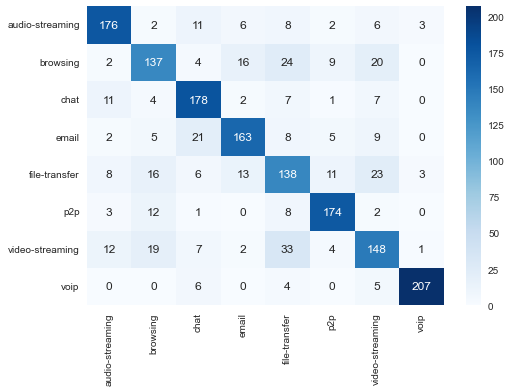

In [249]:
n_df = df_r.copy()
n_df = n_df.drop(['Y', 'YHat', 'Correct'], axis=1)

# n_df.pivot_table(index='label', columns='prediction', fill_value=0, aggfunc=np.sum)
cf = sklearn.metrics.confusion_matrix(df_r['label'], df_r['prediction'])
sns.heatmap(cf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

In [274]:
data = transform_and_split_data(application_dataset_2['Dataset'], 'Application Type', split=.2)


(117620, 63)


In [275]:

y_range     = None
epochs      = 100
classes     = data.classes
cardinality = [4 for _ in range(3)]
layers      = [50 for _ in range(3)]
n_out       = get_c(data.dls)
emb_szs     = get_emb_sz(data.dls.train_ds)

logger_1 = DFLogger()
collector_1 = ModelStatsCallback()
grapher_1 = LazyGraphCallback()
# model_saver = SaveModelCallback(monitor='f1_score')
model_saver = SaveModelCallback(monitor='balanced_accuracy_score')
callbacks_1 = [model_saver, logger_1, collector_1, grapher_1]
# callbacks_1 = [logger_1, collector_1, grapher_1]
config = {'layers': layers, 'cardinality': cardinality, 'enc_sz': 50}
metrics=[accuracy, BalancedAccuracy(),  F1Score(average='macro')]
learner = torch_learner(data.dls, metrics=metrics, cbs=callbacks_1, config=None, model=SPDTabCNN)
learner.model


Torch_Model_Loader(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): SPDTabCNN(
    (layers): Sequential(
      (0): Linear(in_features=64, out_features=105, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Cat(
        (0): Sequential(
          (0): LinBnDrop(
            (0): BatchNorm1d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Linear(in_features=105, out_features=105, bias=False)
            (2): ReLU(inplace=True)
          )
          (1): Cholesky()
          (2): bury_layer()
        )
        (1): Sequential(
          (0): LinBnDrop(
            (0): BatchNorm1d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Linear(in_features=105, out_features=105, 

Better model found at epoch 0 with balanced_accuracy_score value: 0.4164121565808848.
Better model found at epoch 1 with balanced_accuracy_score value: 0.4659312702372277.
Better model found at epoch 2 with balanced_accuracy_score value: 0.562031448634275.
Better model found at epoch 3 with balanced_accuracy_score value: 0.5877418193955677.
Better model found at epoch 4 with balanced_accuracy_score value: 0.6048176265048564.
Better model found at epoch 5 with balanced_accuracy_score value: 0.6179495125961865.
Better model found at epoch 6 with balanced_accuracy_score value: 0.6394148728038187.
Better model found at epoch 7 with balanced_accuracy_score value: 0.6440392433951325.
Better model found at epoch 8 with balanced_accuracy_score value: 0.6684329877211669.
Better model found at epoch 11 with balanced_accuracy_score value: 0.6760328410725227.
Better model found at epoch 13 with balanced_accuracy_score value: 0.6921878225336333.
Better model found at epoch 15 with balanced_accuracy

(#4) [155.26742553710938,0.8686022758483887,0.7377953851238005,0.7678553153671264]

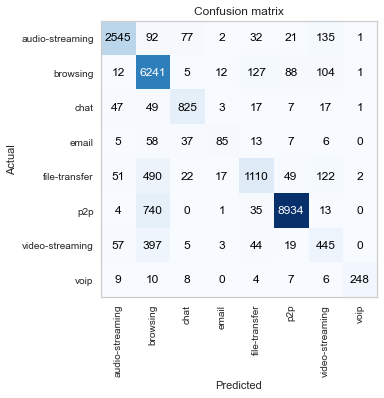

In [276]:

with learner.no_bar():
    learner.fit_one_cycle(epochs)
    results = learner.validate()
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()

results

In [ ]:
confusion_matrix_from_dataset()

In [277]:
logger_1.df

,epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0,0.939441,5.474667,0.731721,0.416412,0.425416,00:35
1,1,0.703689,2.490304,0.777291,0.465931,0.475499,00:36
2,2,0.614659,1.291181,0.810874,0.562031,0.589959,00:36
3,3,0.557115,1.184709,0.821416,0.587742,0.607707,00:37
4,4,0.537306,3.112586,0.827070,0.604818,0.623179,00:36
...,...,...,...,...,...,...,...
97,97,0.312288,73.368317,0.745366,0.633493,0.661295,00:51
98,98,0.283436,130.307892,0.865584,0.731081,0.762806,00:51
99,99,0.311865,86.001656,0.851343,0.702213,0.737477,00:51
100,-1,0.000000,155.267426,0.868602,0.737795,0.767855,00:03


In [278]:
old_model = learner.model

In [ ]:

y_range     = None
epochs      = 100
classes     = data.classes
cardinality = [4 for _ in range(3)]
layers      = [50 for _ in range(3)]
n_out       = get_c(data.dls)
emb_szs     = get_emb_sz(data.dls.train_ds)

logger_1 = DFLogger()
collector_1 = ModelStatsCallback()
grapher_1 = LazyGraphCallback()
# model_saver = SaveModelCallback(monitor='f1_score')
model_saver = SaveModelCallback(monitor='balanced_accuracy_score')
callbacks_1 = [model_saver, logger_1, collector_1, grapher_1]
# callbacks_1 = [logger_1, collector_1, grapher_1]
config = {'layers': layers, 'cardinality': cardinality, 'enc_sz': 50}
metrics=[accuracy, BalancedAccuracy(),  F1Score(average='macro')]
learner = torch_learner(data.dls, metrics=metrics, cbs=callbacks_1, config=None, model=SPDTabCNN)
learner.model = old_model


In [ ]:
print(f'Last Execution: {datetime.datetime.now()}')
assert False, 'Nothing after this point is included in the study'